<h1 style="text-align: center;">LoanTap Logistic Regression</h1><br>

![LoanTap](LoanTap.png) 

### About LoanTap 
LoanTap is an online platform committed to delivering customized loan products to millennials. They innovate in an otherwise dull loan segment, to deliver instant, flexible loans on consumer friendly terms to salaried professionals and businessmen.

The data science team at LoanTap is building an underwriting layer to determine the creditworthiness of MSMEs as well as individuals.

LoanTap deploys formal credit to salaried individuals and businesses 4 main financial instruments:
- Personal Loan
- EMI Free Loan
- Personal Overdraft
- Advance Salary Loan
This case study will focus on the underwriting process behind Personal Loan only

### Business Problem
Given a set of attributes for an Individual, determine if a credit line should be extended to them. If so, what should the repayment terms be in business recommendations?

### Columns info:-
- loan_amnt : The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
- term : The number of payments on the loan. Values are in months and can be either 36 or 60.
- int_rate : Interest Rate on the loan
- installment : The monthly payment owed by the borrower if the loan originates.
- grade : LoanTap assigned loan grade
- sub_grade : LoanTap assigned loan subgrade
- emp_title :The job title supplied by the Borrower when applying for the loan.*
- emp_length : Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
- home_ownership : The home ownership status provided by the borrower during registration or obtained from the credit report.
- annual_inc : The self-reported annual income provided by the borrower during registration.
- verification_status : Indicates if income was verified by LoanTap, not verified, or if the income source was verified
- issue_d : The month which the loan was funded
- loan_status : Current status of the loan - Target Variable
- purpose : A category provided by the borrower for the loan request.
- title : The loan title provided by the borrower
- dti : A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LoanTap loan, divided by the borrower’s self-reported monthly income.
- earliest_cr_line :The month the borrower's earliest reported credit line was opened
- open_acc : The number of open credit lines in the borrower's credit file.
- pub_rec : Number of derogatory public records
- revol_bal : Total credit revolving balance
- revol_util : Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
- total_acc : The total number of credit lines currently in the borrower's credit file
- initial_list_status : The initial listing status of the loan. Possible values are – W, F
- application_type : Indicates whether the loan is an individual application or a joint application with two co-borrowers
- mort_acc : Number of mortgage accounts.
- pub_rec_bankruptcies : Number of public record bankruptcies
- Address: Address of the individual

In [1]:
import math
from datetime import datetime

import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns # All palettes -> https://r02b.github.io/seaborn_palettes/
sns.set_theme(style="whitegrid")

import matplotlib.pylab as pylab
params = {
    'figure.titlesize': 'xx-large',
    'legend.fontsize': 'x-large',
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large',
    'axes.formatter.limits': (-10, 10)
}
pylab.rcParams.update(params)

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay, RocCurveDisplay
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('logistic_regression.csv')
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


In [3]:
# checking shape
df.shape

(396030, 27)

In [4]:
#columns info
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'purpose', 'title',
       'dti', 'earliest_cr_line', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'application_type',
       'mort_acc', 'pub_rec_bankruptcies', 'address'],
      dtype='object')

In [5]:
# Unique data for each column
df.nunique()

loan_amnt                 1397
term                         2
int_rate                   566
installment              55706
grade                        7
sub_grade                   35
emp_title               173105
emp_length                  11
home_ownership               6
annual_inc               27197
verification_status          3
issue_d                    115
loan_status                  2
purpose                     14
title                    48816
dti                       4262
earliest_cr_line           684
open_acc                    61
pub_rec                     20
revol_bal                55622
revol_util                1226
total_acc                  118
initial_list_status          2
application_type             3
mort_acc                    33
pub_rec_bankruptcies         9
address                 393700
dtype: int64

In [6]:
# Checking the distribution of the outcome labels
df.loan_status.value_counts(normalize=True)*100

loan_status
Fully Paid     80.387092
Charged Off    19.612908
Name: proportion, dtype: float64

In [7]:
# Statistical summary of the dataset
df.describe(include='all')

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
count,396030.000000,396030,396030.000000,396030.000000,396030,396030,373103,377729,396030,3.960300e+05,396030,396030,396030,396030,394274,396030.000000,396030,396030.000000,396030.000000,3.960300e+05,395754.000000,396030.000000,396030,396030,358235.000000,395495.000000,396030
unique,NaN,2,NaN,NaN,7,35,173105,11,6,NaN,3,115,2,14,48816,NaN,684,NaN,NaN,NaN,NaN,NaN,2,3,NaN,NaN,393700
top,NaN,36 months,NaN,NaN,B,B3,Teacher,10+ years,MORTGAGE,NaN,Verified,Oct-2014,Fully Paid,debt_consolidation,Debt consolidation,NaN,Oct-2000,NaN,NaN,NaN,NaN,NaN,f,INDIVIDUAL,NaN,NaN,USCGC Smith\r\nFPO AE 70466
freq,NaN,302005,NaN,NaN,116018,26655,4389,126041,198348,NaN,139563,14846,318357,234507,152472,NaN,3017,NaN,NaN,NaN,NaN,NaN,238066,395319,NaN,NaN,8
mean,14113.888089,NaN,13.639400,431.849698,NaN,NaN,NaN,NaN,NaN,7.420318e+04,NaN,NaN,NaN,NaN,NaN,17.379514,NaN,11.311153,0.178191,1.584454e+04,53.791749,25.414744,NaN,NaN,1.813991,0.121648,NaN
std,8357.441341,NaN,4.472157,250.727790,NaN,NaN,NaN,NaN,NaN,6.163762e+04,NaN,NaN,NaN,NaN,NaN,18.019092,NaN,5.137649,0.530671,2.059184e+04,24.452193,11.886991,NaN,NaN,2.147930,0.356174,NaN
min,500.000000,NaN,5.320000,16.080000,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000e+00,0.000000,2.000000,NaN,NaN,0.000000,0.000000,NaN
25%,8000.000000,NaN,10.490000,250.330000,NaN,NaN,NaN,NaN,NaN,4.500000e+04,NaN,NaN,NaN,NaN,NaN,11.280000,NaN,8.000000,0.000000,6.025000e+03,35.800000,17.000000,NaN,NaN,0.000000,0.000000,NaN
50%,12000.000000,NaN,13.330000,375.430000,NaN,NaN,NaN,NaN,NaN,6.400000e+04,NaN,NaN,NaN,NaN,NaN,16.910000,NaN,10.000000,0.000000,1.118100e+04,54.800000,24.000000,NaN,NaN,1.000000,0.000000,NaN
75%,20000.000000,NaN,16.490000,567.300000,NaN,NaN,NaN,NaN,NaN,9.000000e+04,NaN,NaN,NaN,NaN,NaN,22.980000,NaN,14.000000,0.000000,1.962000e+04,72.900000,32.000000,NaN,NaN,3.000000,0.000000,NaN


In [8]:
categorical_columns = df.select_dtypes(exclude=[np.number]).columns.to_list()
numerical_columns = df.select_dtypes(include=[np.number]).columns.to_list()

categorical_columns, numerical_columns

(['term',
  'grade',
  'sub_grade',
  'emp_title',
  'emp_length',
  'home_ownership',
  'verification_status',
  'issue_d',
  'loan_status',
  'purpose',
  'title',
  'earliest_cr_line',
  'initial_list_status',
  'application_type',
  'address'],
 ['loan_amnt',
  'int_rate',
  'installment',
  'annual_inc',
  'dti',
  'open_acc',
  'pub_rec',
  'revol_bal',
  'revol_util',
  'total_acc',
  'mort_acc',
  'pub_rec_bankruptcies'])

In [9]:
def describe_cat_column(column):
    print(column)
    print('-'*100)
    print(f"Unique values of {column} are : ", sorted(list(df[column].unique())))
    print('-'*100)
    
    print(df[column].value_counts())
    
    plt.figure(figsize=(20, 10), dpi=200)
    sns.countplot(x = column, hue = 'loan_status', data=df)
    plt.show()
    print('-'*100)

term
----------------------------------------------------------------------------------------------------
Unique values of term are :  [' 36 months', ' 60 months']
----------------------------------------------------------------------------------------------------
term
 36 months    302005
 60 months     94025
Name: count, dtype: int64


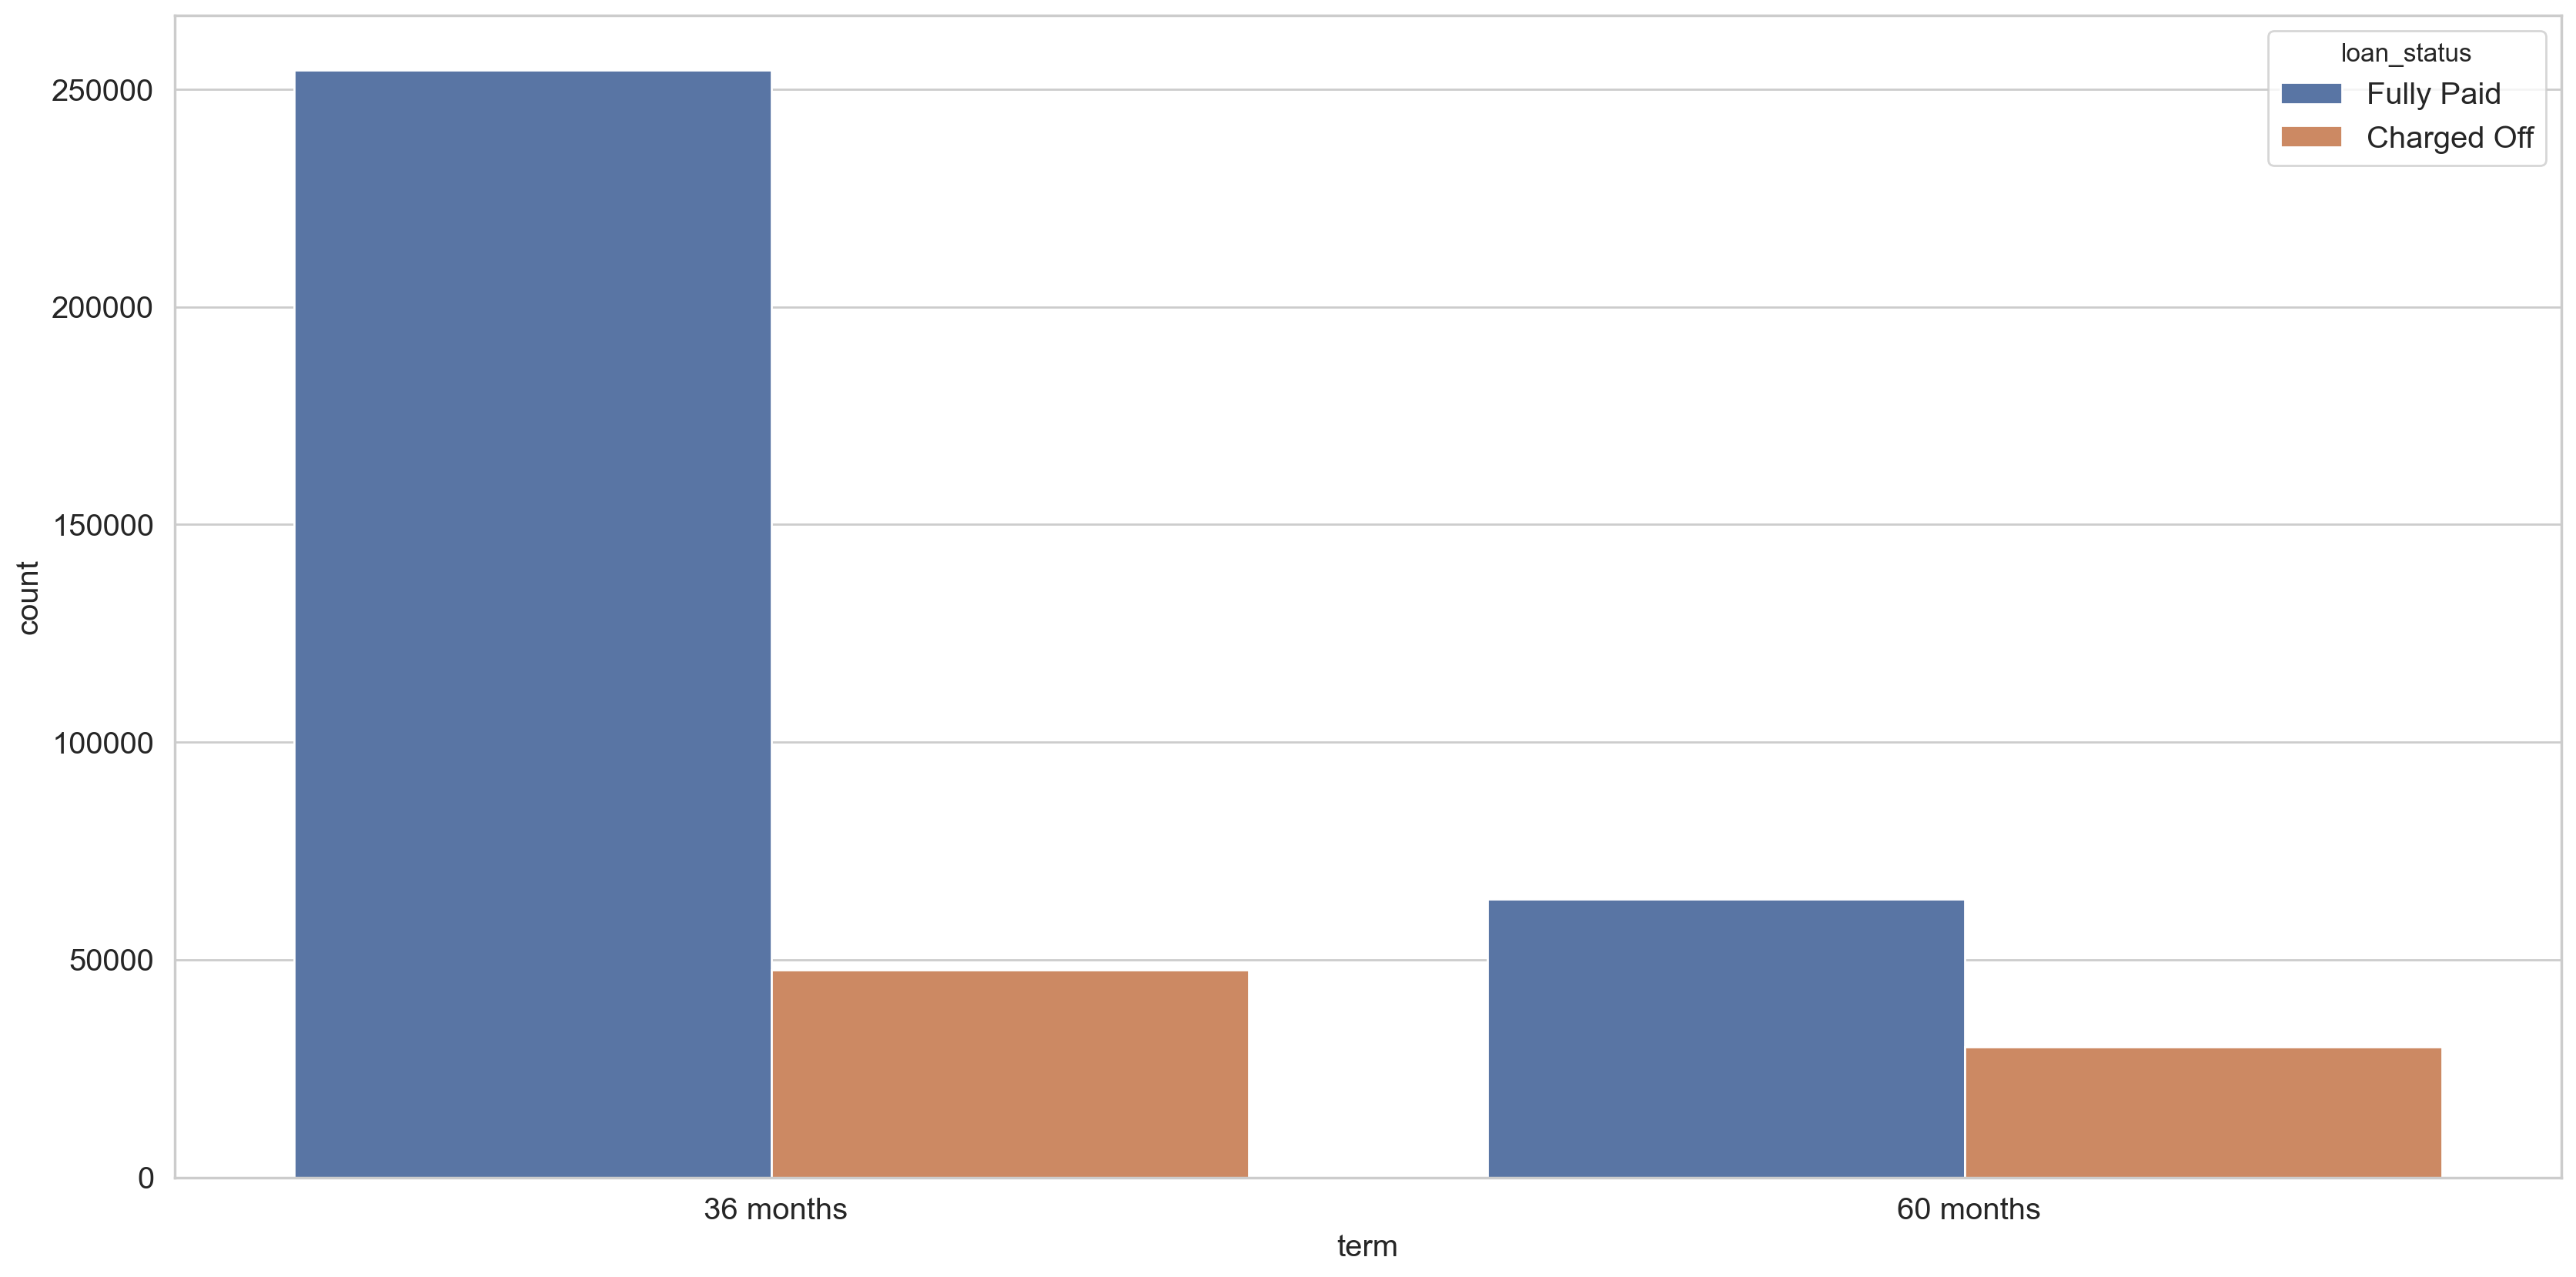

----------------------------------------------------------------------------------------------------


In [10]:
describe_cat_column('term')

In [11]:
def draw_plot_numerical(column, bins = 15, color='c'):
    fig = plt.figure(figsize = (16, 6), dpi=100)

    fig1 = fig.add_subplot(2,1,1)
    sns.histplot(x=df[column], kde='reg', bins=bins, color=color)
    plt.axvline(df[column].mean(), color="g", label='Mean')
    plt.axvline(df[column].median(), color="black", label = 'Median')
    plt.axvline(df[column].mode()[0], color="r", label = 'Mode')
    plt.legend()
    plt.ylabel('')
    plt.xlabel('')

    fig.add_subplot(2,1,2, sharex=fig1)
    sns.boxplot(x=df[column], color=color)

    plt.suptitle(f'Analying {column} column', fontsize=20)
    plt.axvline(df[column].mean(), color="g", label='Mean')
    plt.axvline(df[column].median(), color="black", label = 'Median')
    plt.axvline(df[column].mode()[0], color="r", label = 'Mode')
    plt.xlabel('')
    plt.xticks(np.linspace(df[column].min(), df[column].max(), num=bins+1))
    plt.show()
    
def describe_and_find_outliers(column):
    print('-'*100)
    print(df[column].describe().to_string())
    
    Q1 = df[column].quantile(.25)
    Q3 = df[column].quantile(.75)
    IQR = Q3 - Q1

    right = df[df[column] > (Q3 + 1.5 * IQR)]
    left = df[df[column] < (Q1 - 1.5 * IQR)]
    
    print('-'*100)
    if(len(left) > 0):
        print('\nOutliers on left extreme:-\n')
        print(f'Total {len(left)} outliers which are lesser than {Q1 - 1.5 * IQR}')
    else:
        print('No outliers on left extreme')
        
    print('-'*100)
    if(len(right) > 0) :
        print('\nOutliers on right extreme:-\n')
        print(f'Total {len(right)} outliers which are greater than {Q3 + 1.5 * IQR}')
    else:
        print('No outliers on right extreme')
    
    print('-'*100)
    
    return left, right

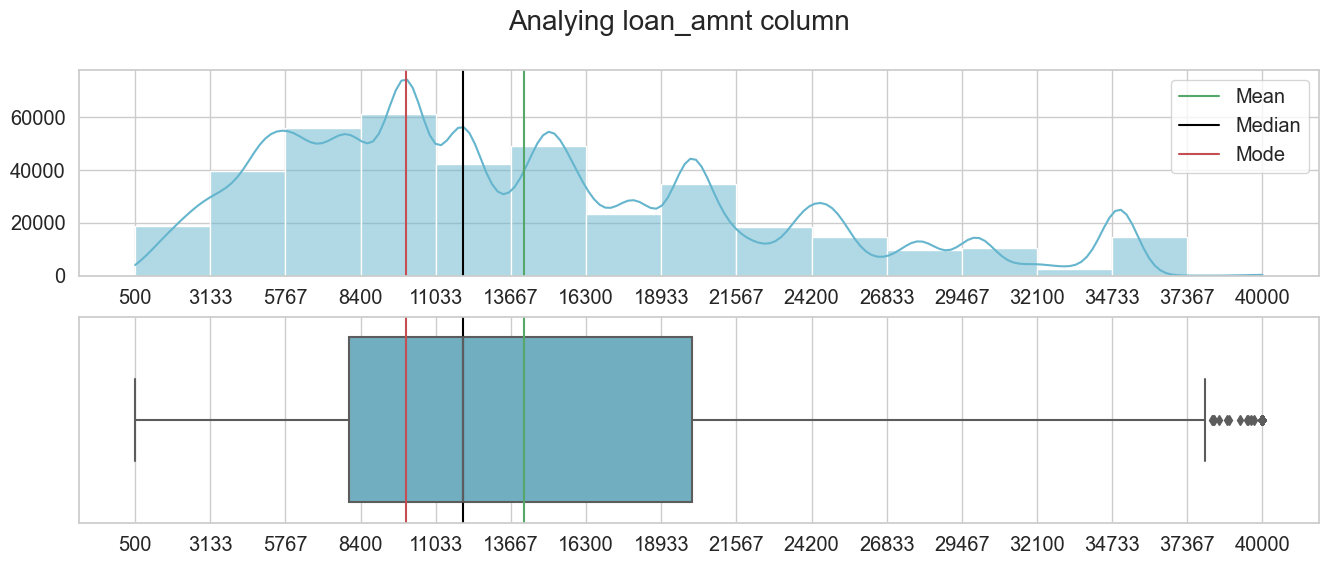

----------------------------------------------------------------------------------------------------
count    396030.000000
mean      14113.888089
std        8357.441341
min         500.000000
25%        8000.000000
50%       12000.000000
75%       20000.000000
max       40000.000000
----------------------------------------------------------------------------------------------------
No outliers on left extreme
----------------------------------------------------------------------------------------------------

Outliers on right extreme:-

Total 191 outliers which are greater than 38000.0
----------------------------------------------------------------------------------------------------


In [12]:
column = 'loan_amnt'

draw_plot_numerical(column, 15)
temp_left_outliers, temp_right_outliers = describe_and_find_outliers(column)

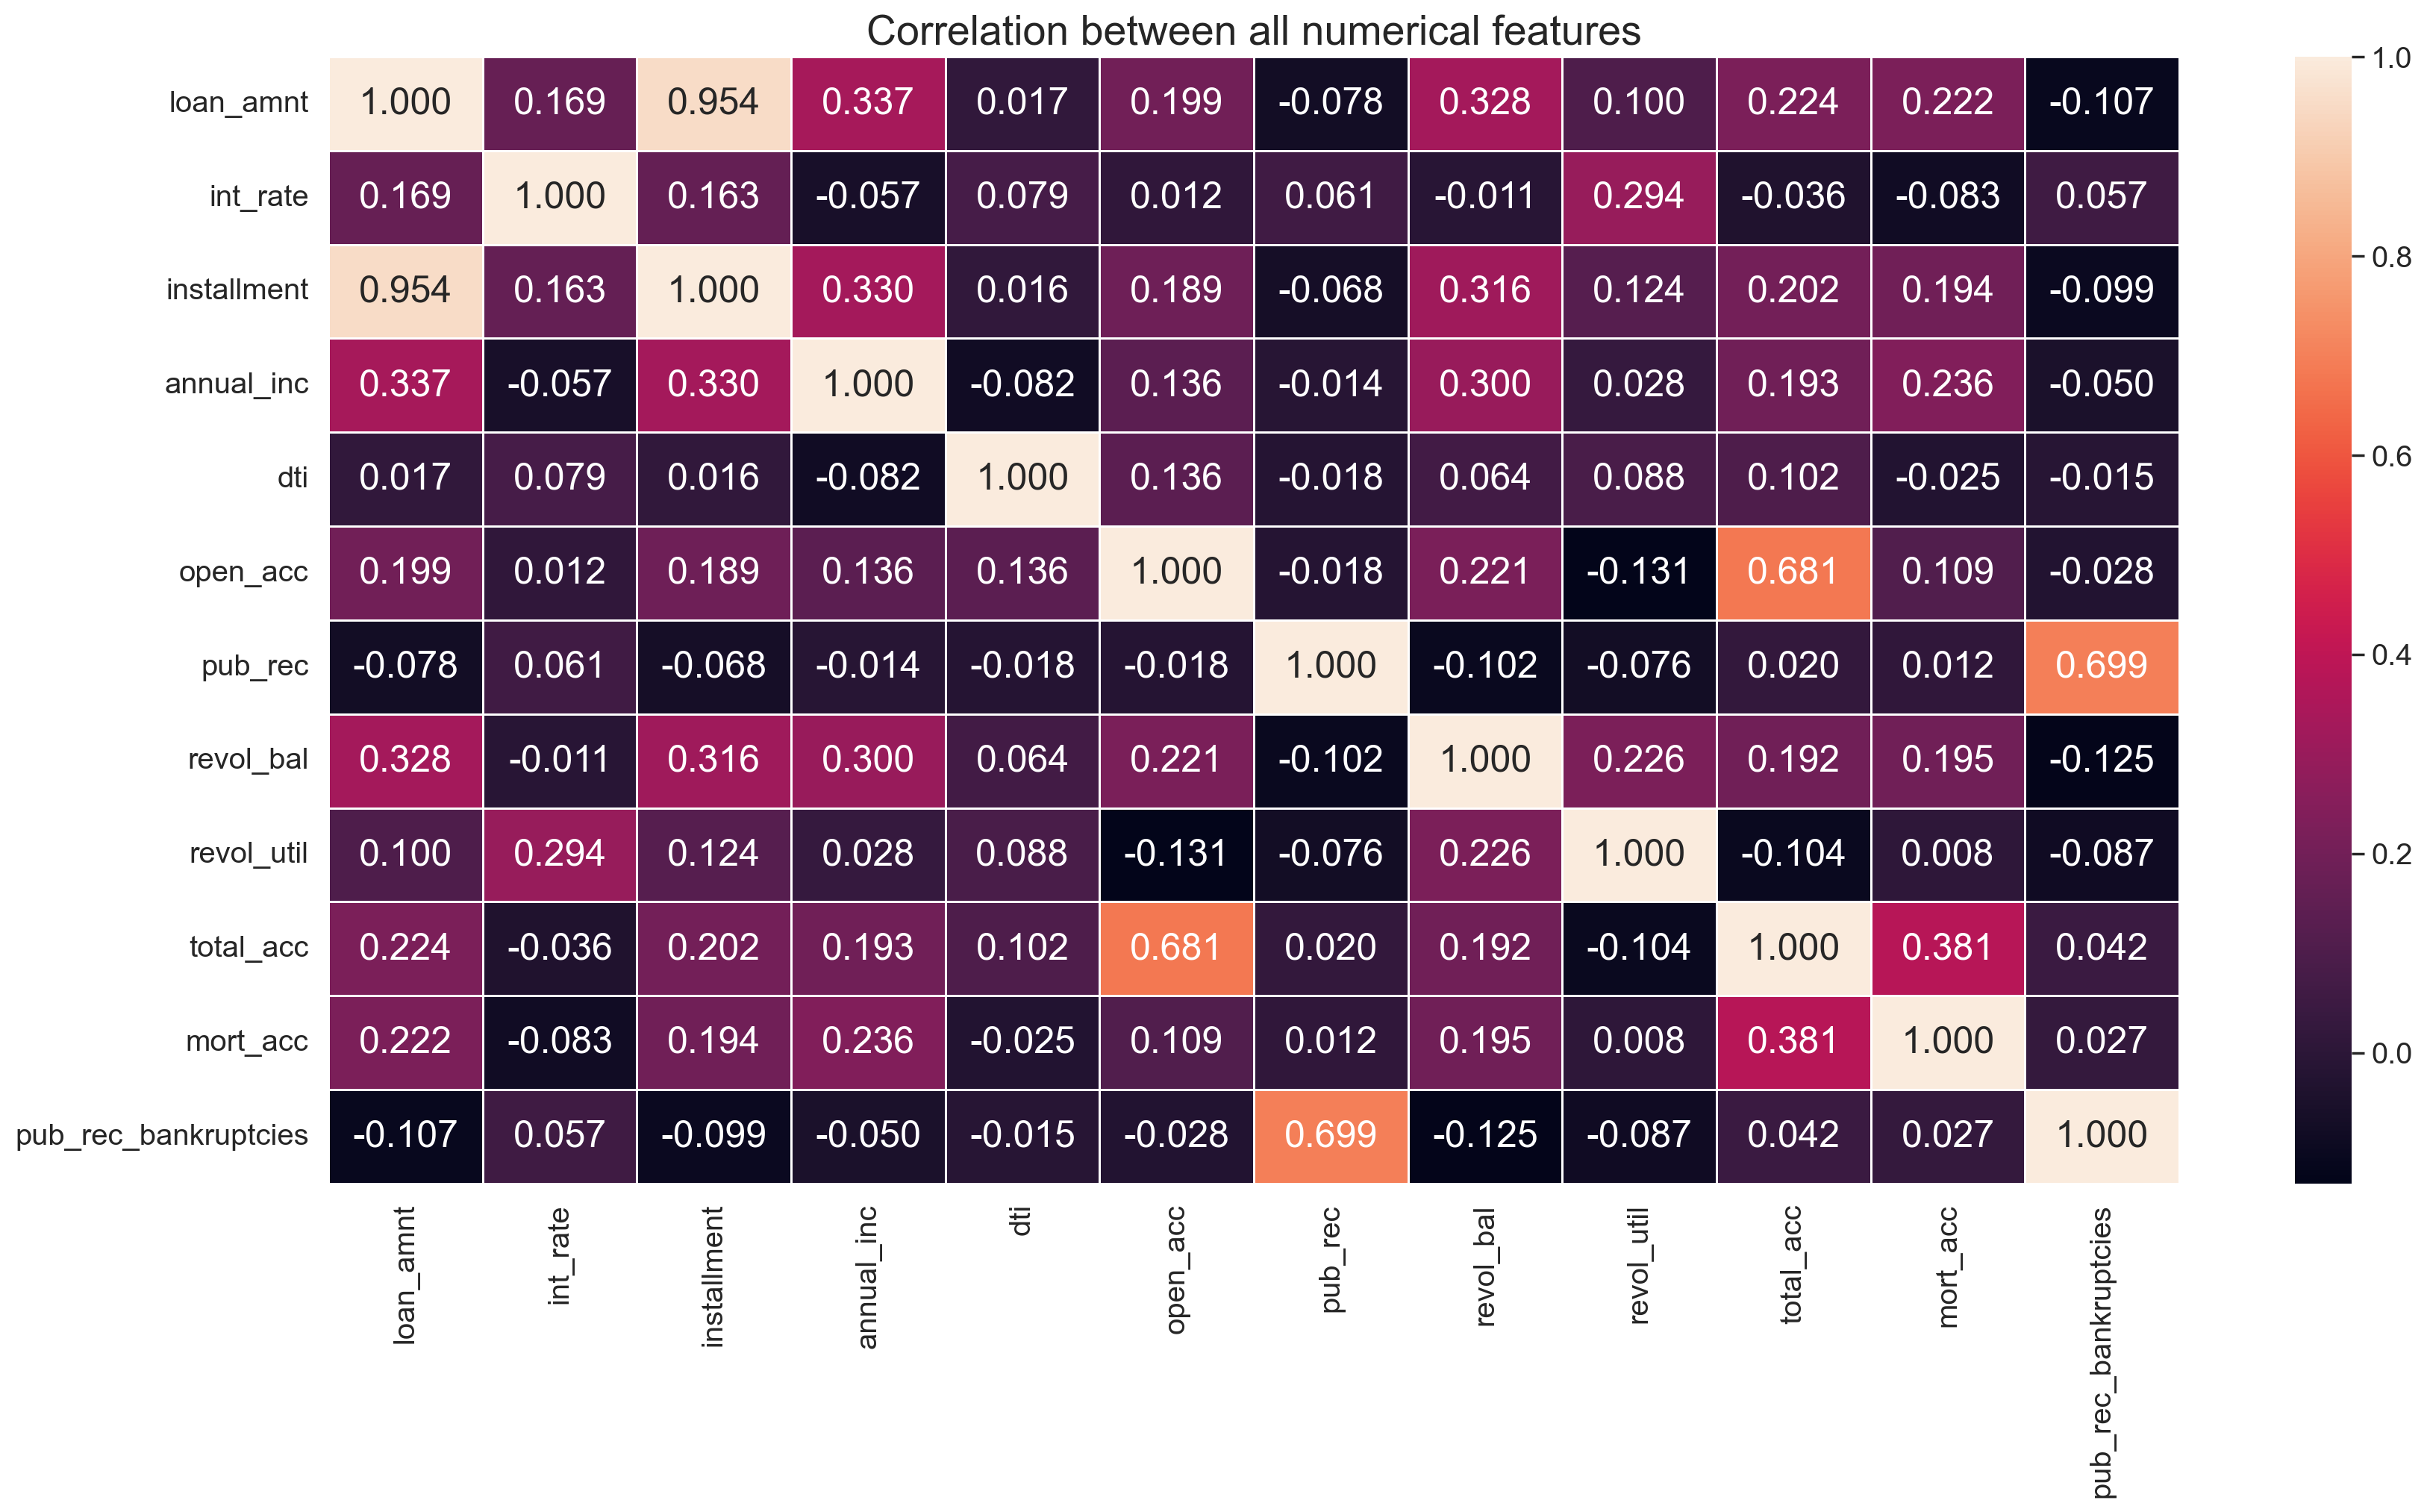

In [13]:
plt.figure(figsize=(20, 10), dpi=200)
sns.heatmap(data=df[numerical_columns].corr(), annot=True,
            linewidths=1, annot_kws={"fontsize":18}, fmt='.3f')

plt.title('Correlation between all numerical features', fontsize=20)
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=90)
plt.show()

In [14]:
# Almost perfect correlation between "loan_amnt" the "installment" feature

# installment: The monthly payment owed by the borrower if the loan originates.
# loan_amnt: The listed amount of the loan applied for by the borrower. 

# Thus dropping either one of those columns.

In [15]:
df.drop(columns=['installment'],axis=1,inplace=True)

In [16]:
# The no. of people who have paid fully and the no. of people who are charged off
df.groupby(by='loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,77673.0,15126.300967,8505.090557,1000.0,8525.0,14000.0,20000.0,40000.0
Fully Paid,318357.0,13866.878771,8302.319699,500.0,7500.0,12000.0,19225.0,40000.0


In [17]:
# The majority of ownership as Mortgage and Rent
df['home_ownership'].value_counts()

home_ownership
MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          112
NONE            31
ANY              3
Name: count, dtype: int64

In [18]:
# Combining the minority classes as 'OTHERS'
df.loc[(df.home_ownership == 'ANY') | (df.home_ownership == 'NONE'), 'home_ownership'] = 'OTHER'  
df.home_ownership.value_counts()

home_ownership
MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          146
Name: count, dtype: int64

In [19]:
# Checking the distribution of 'Other'
df.loc[df['home_ownership']=='OTHER','loan_status'].value_counts()

loan_status
Fully Paid     123
Charged Off     23
Name: count, dtype: int64

In [20]:
# Converting string to date-time format
df['issue_d']=pd.to_datetime(df['issue_d'])
df['earliest_cr_line']=pd.to_datetime(df['earliest_cr_line'])

In [21]:
# saw some issues in title(Looks like it was filled manually and needs some fixing)
df['title']=df.title.str.lower()
df['title'].value_counts()[:20]

title
debt consolidation           168108
credit card refinancing       51781
home improvement              17117
other                         12993
consolidation                  5583
major purchase                 4998
debt consolidation loan        3513
business                       3017
medical expenses               2820
credit card consolidation      2638
personal loan                  2460
car financing                  2160
credit card payoff             1904
consolidation loan             1887
vacation                       1866
credit card refinance          1832
moving and relocation          1693
consolidate                    1528
personal                       1465
home buying                    1196
Name: count, dtype: int64

In [22]:
# The grade of majority of people those who have fully paid the loan is 'B' and have subgrade 'B3'.
# So from that we can infer that people with grade 'B' and subgrade 'B3' are more likely to fully pay the loan.

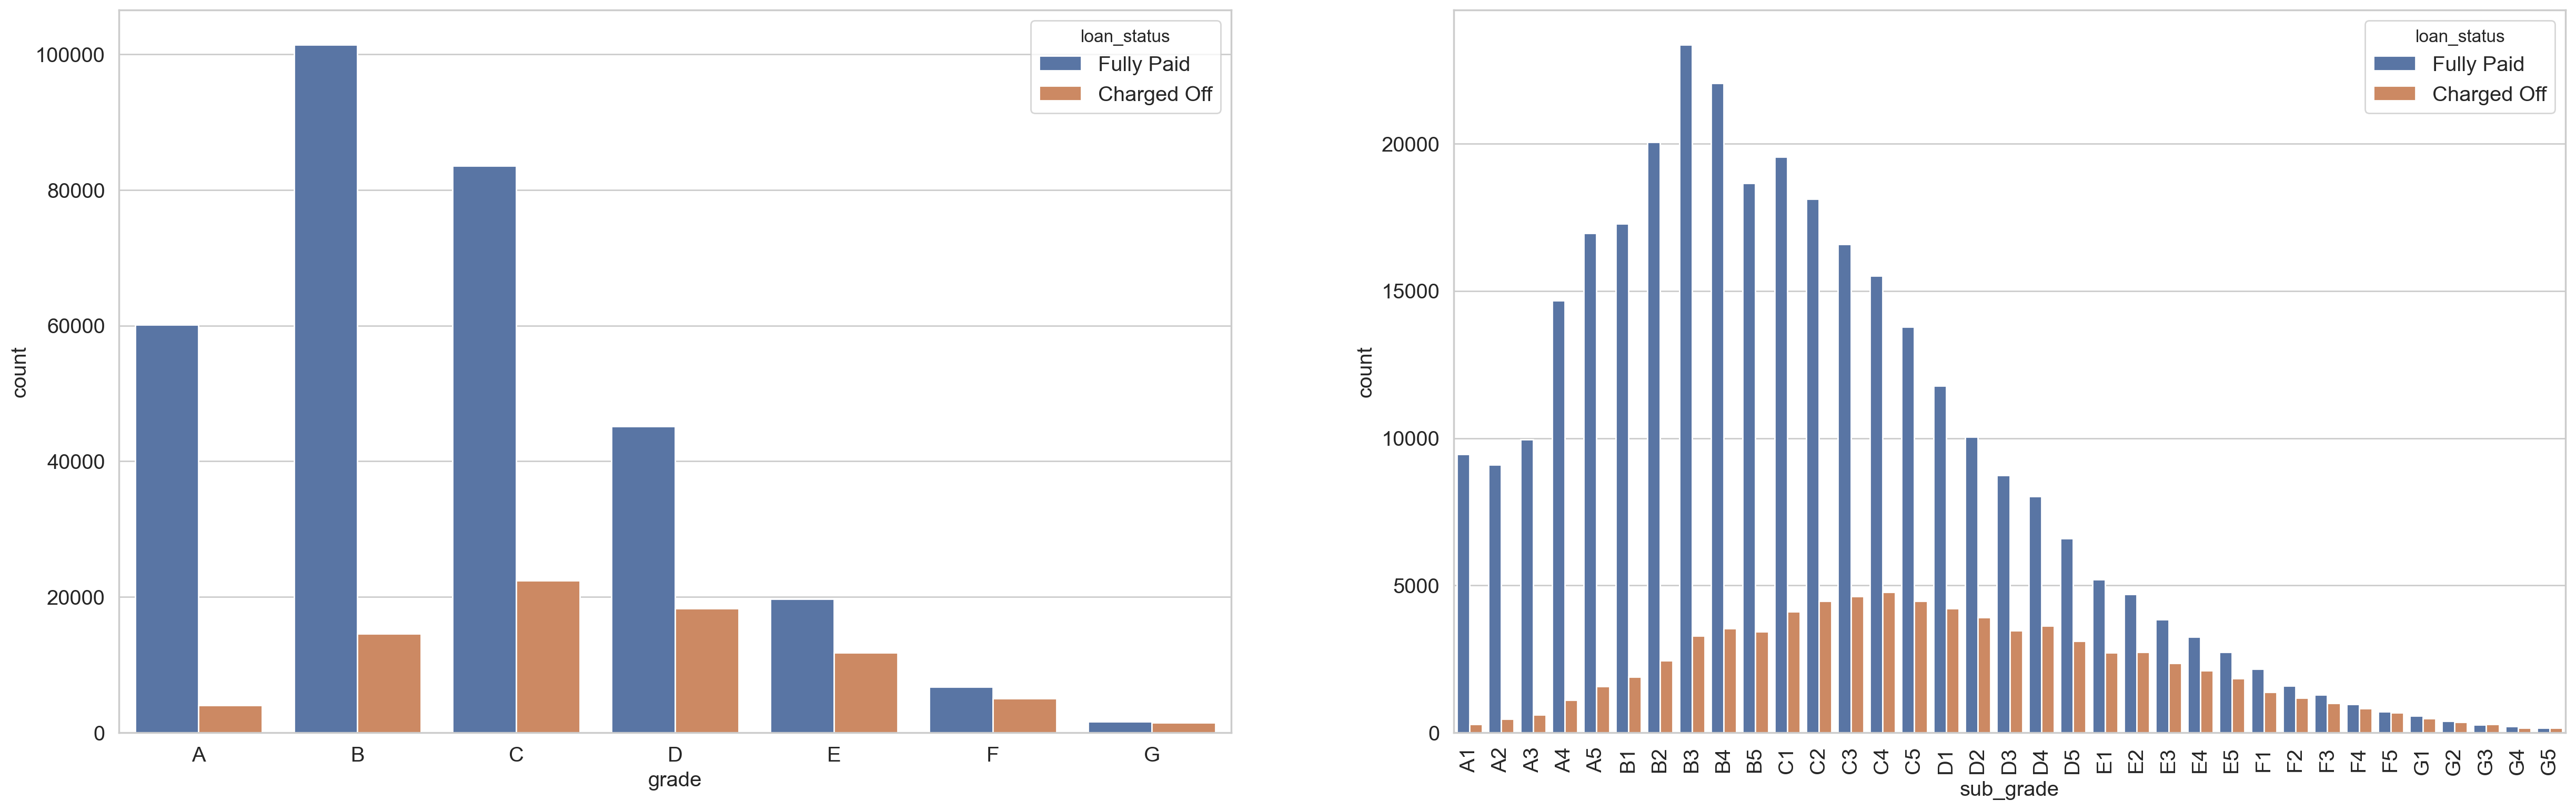

In [23]:
plt.figure(figsize=(30, 20),dpi = 200)

plt.subplot(2, 2, 1)
grade = sorted(df.grade.unique().tolist())
sns.countplot(x='grade', data=df, hue='loan_status', order=grade)

plt.subplot(2, 2, 2)
sub_grade = sorted(df.sub_grade.unique().tolist())
g = sns.countplot(x='sub_grade', data=df, hue='loan_status', order=sub_grade)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
plt.show()

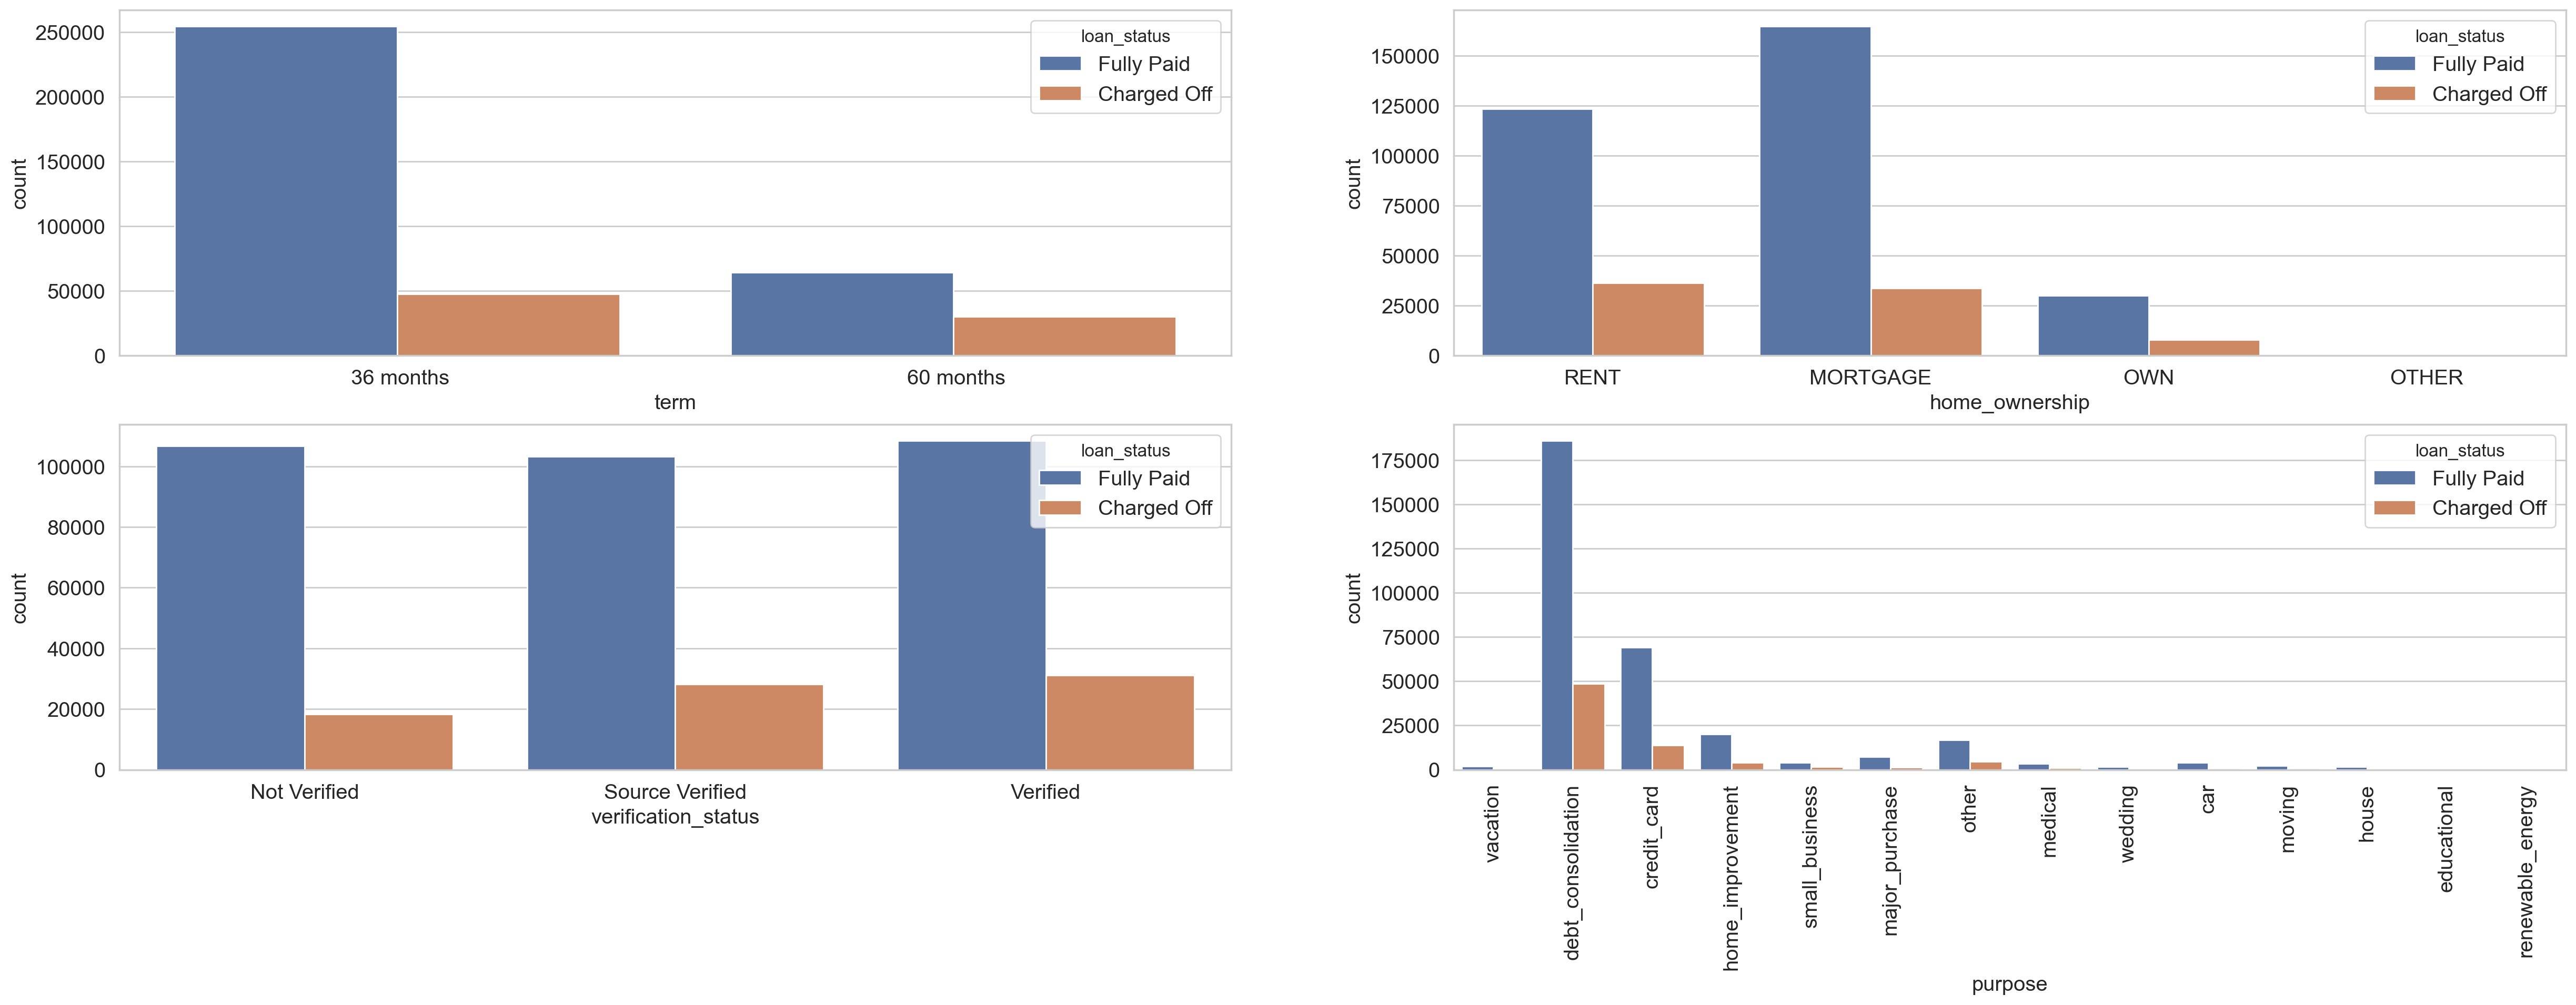

In [24]:
plt.figure(figsize=(30, 20),dpi = 200)

plt.subplot(4,2,1)
sns.countplot(x='term',data=df,hue='loan_status')

plt.subplot(4,2,2)
sns.countplot(x='home_ownership',data=df,hue='loan_status')

plt.subplot(4,2,3)
sns.countplot(x='verification_status',data=df,hue='loan_status')

plt.subplot(4,2,4)
g=sns.countplot(x='purpose',data=df,hue='loan_status')
g.set_xticklabels(g.get_xticklabels(),rotation=90)
plt.show()

In [25]:
# Manager and Teacher are the most afforded loan on titles

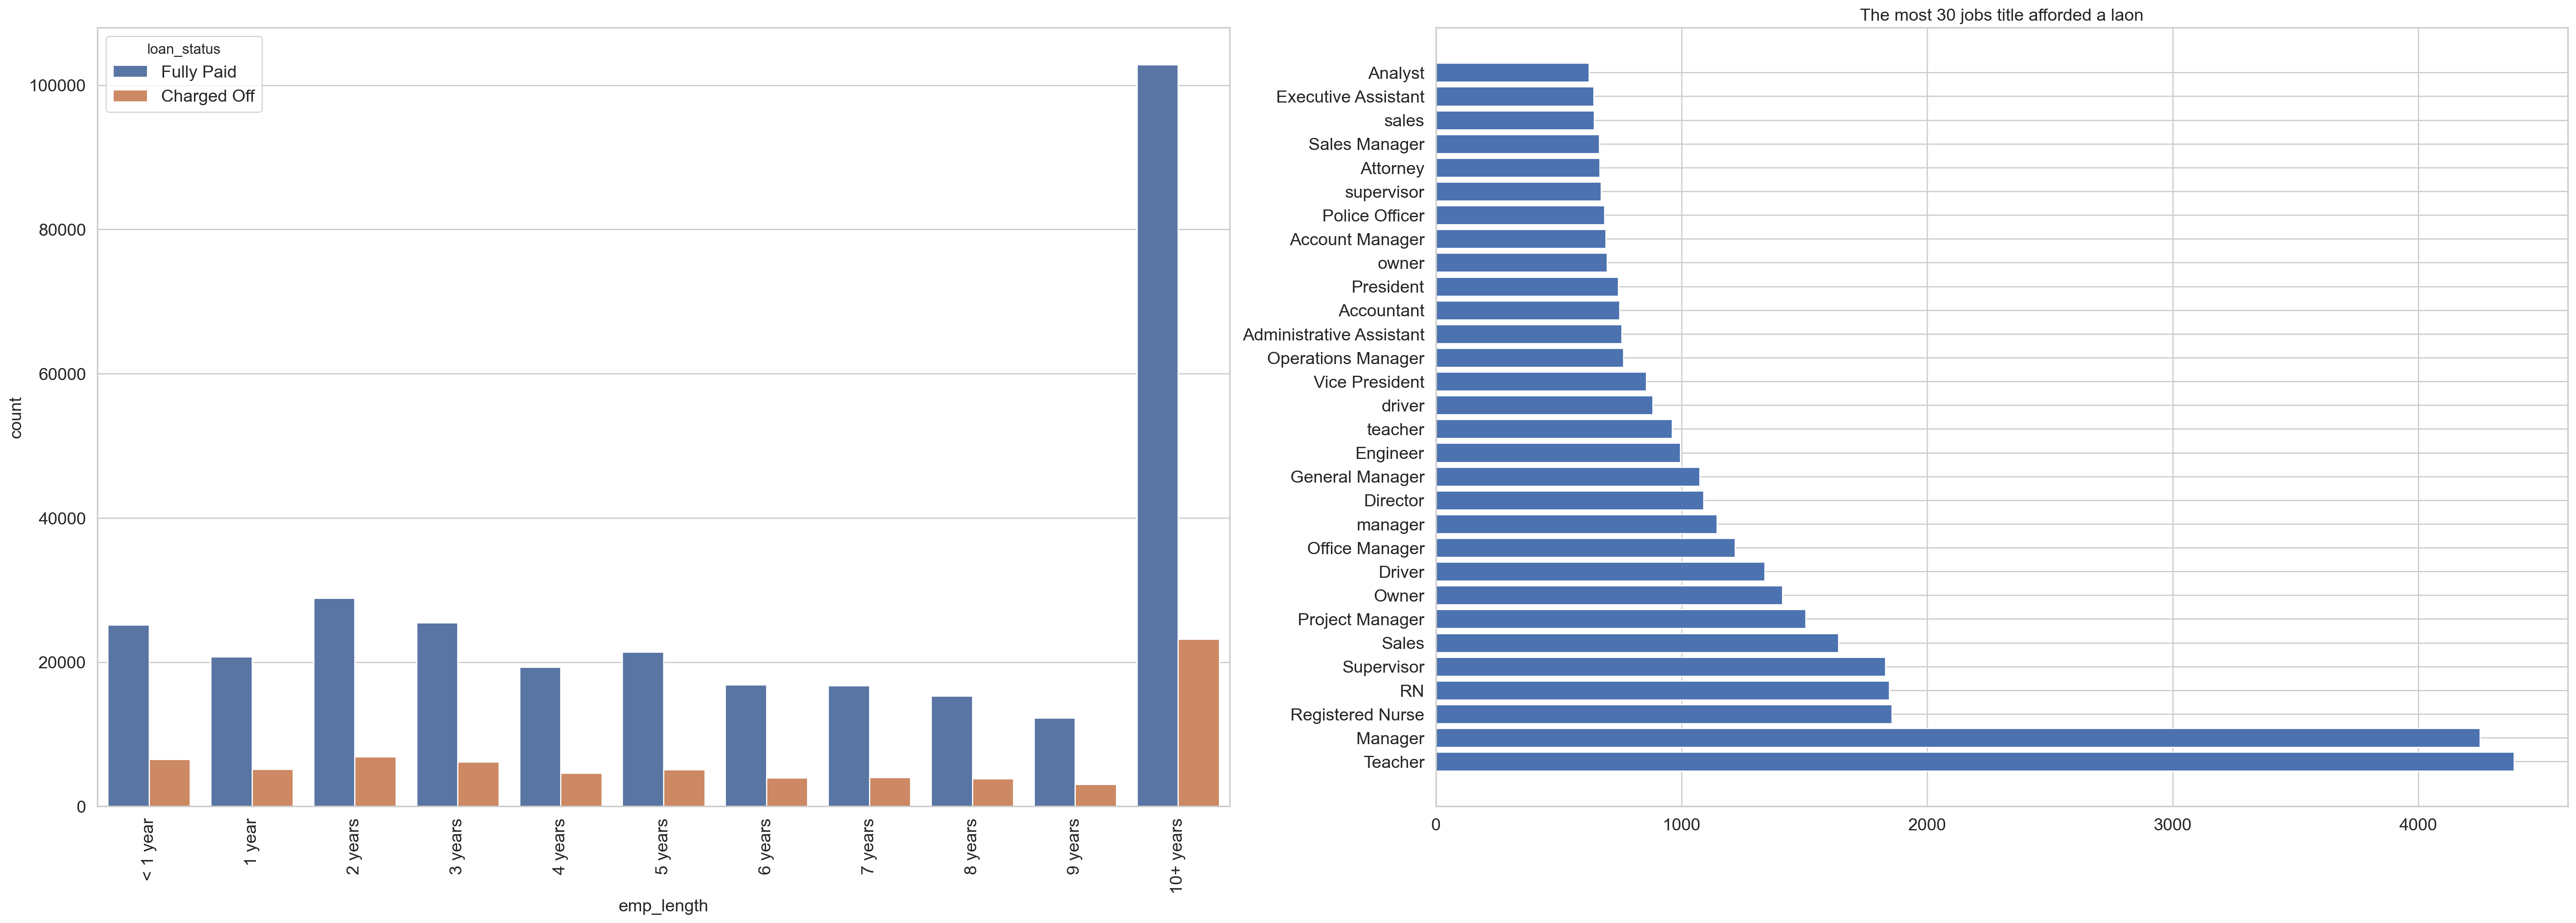

In [26]:
plt.figure(figsize=(30, 20),dpi = 200)

plt.subplot(2,2,1)
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', 
          '6 years', '7 years', '8 years', '9 years', '10+ years',]
g=sns.countplot(x='emp_length',data=df,hue='loan_status',order=order)
g.set_xticklabels(g.get_xticklabels(),rotation=90)

plt.subplot(2,2,2)
plt.barh(df.emp_title.value_counts()[:30].index,df.emp_title.value_counts()[:30])
plt.title("The most 30 jobs title afforded a laon")
plt.tight_layout()

In [27]:
# Manager and Teacher are the most afforded loan on titles

pub_rec
----------------------------------------------------------------------------------------------------
Unique values of pub_rec are :  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 15.0, 17.0, 19.0, 24.0, 40.0, 86.0]
----------------------------------------------------------------------------------------------------
pub_rec
0.0     338272
1.0      49739
2.0       5476
3.0       1521
4.0        527
5.0        237
6.0        122
7.0         56
8.0         34
9.0         12
10.0        11
11.0         8
13.0         4
12.0         4
19.0         2
40.0         1
17.0         1
86.0         1
24.0         1
15.0         1
Name: count, dtype: int64


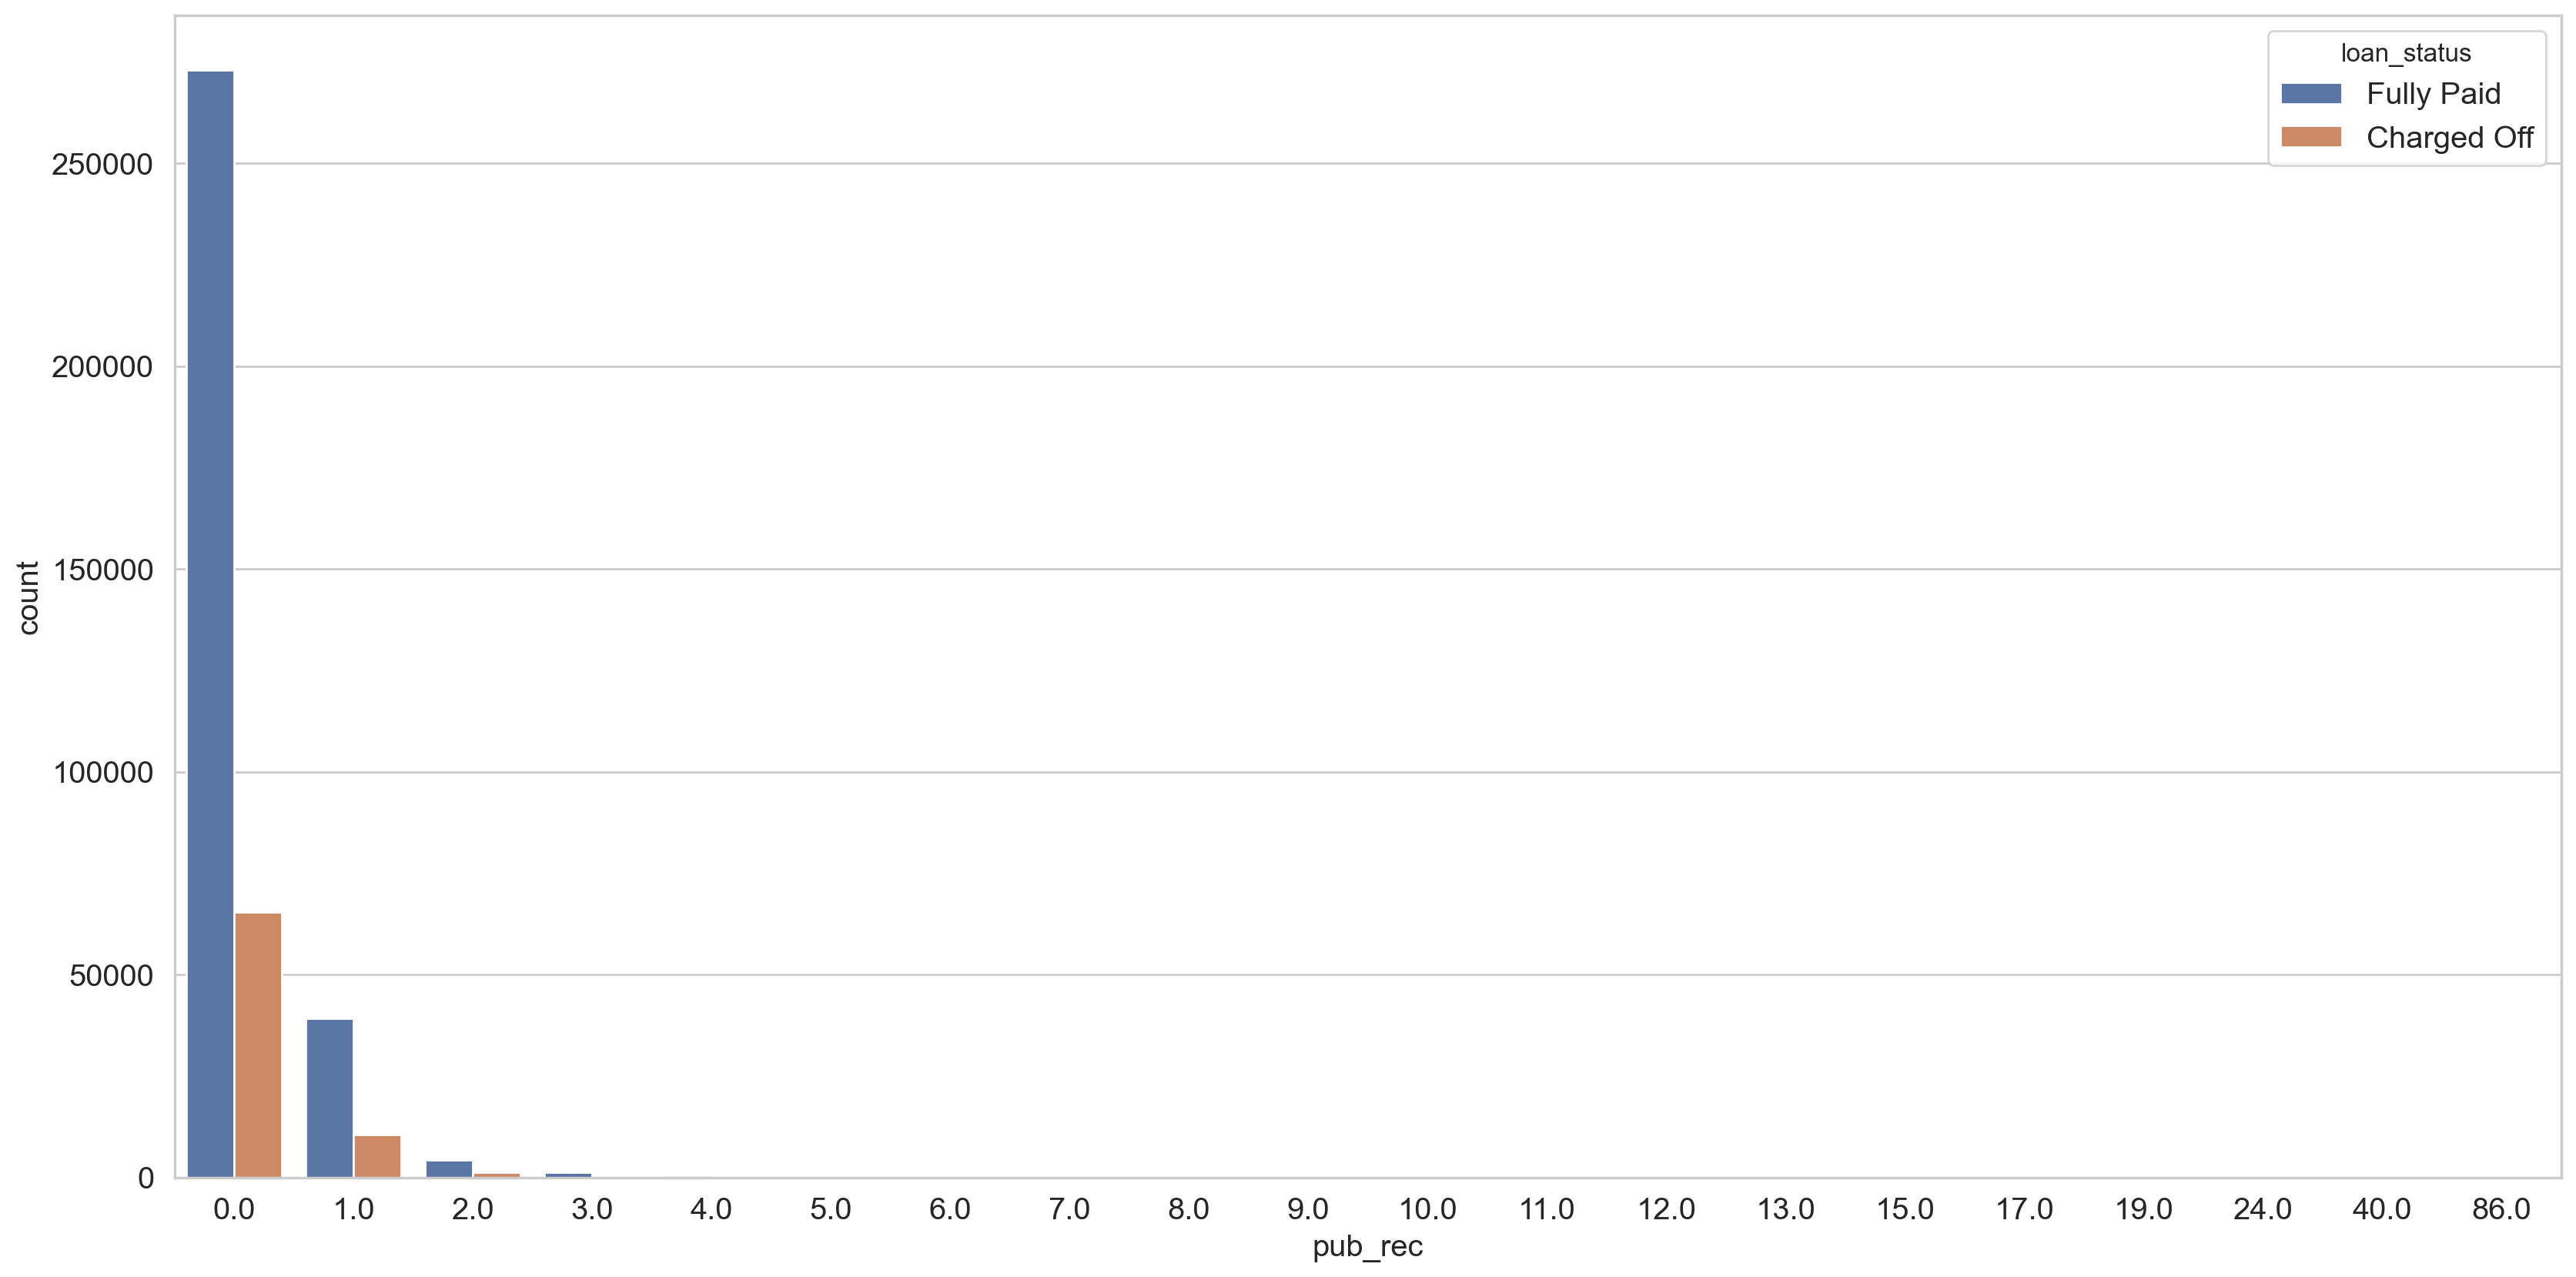

----------------------------------------------------------------------------------------------------


In [28]:
describe_cat_column('pub_rec')

mort_acc
----------------------------------------------------------------------------------------------------
Unique values of mort_acc are :  [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, nan, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 30.0, 31.0, 32.0, 34.0]
----------------------------------------------------------------------------------------------------
mort_acc
0.0     139777
1.0      60416
2.0      49948
3.0      38049
4.0      27887
5.0      18194
6.0      11069
7.0       6052
8.0       3121
9.0       1656
10.0       865
11.0       479
12.0       264
13.0       146
14.0       107
15.0        61
16.0        37
17.0        22
18.0        18
19.0        15
20.0        13
24.0        10
22.0         7
21.0         4
25.0         4
27.0         3
32.0         2
31.0         2
23.0         2
26.0         2
28.0         1
30.0         1
34.0         1
Name: count, dtype: int64


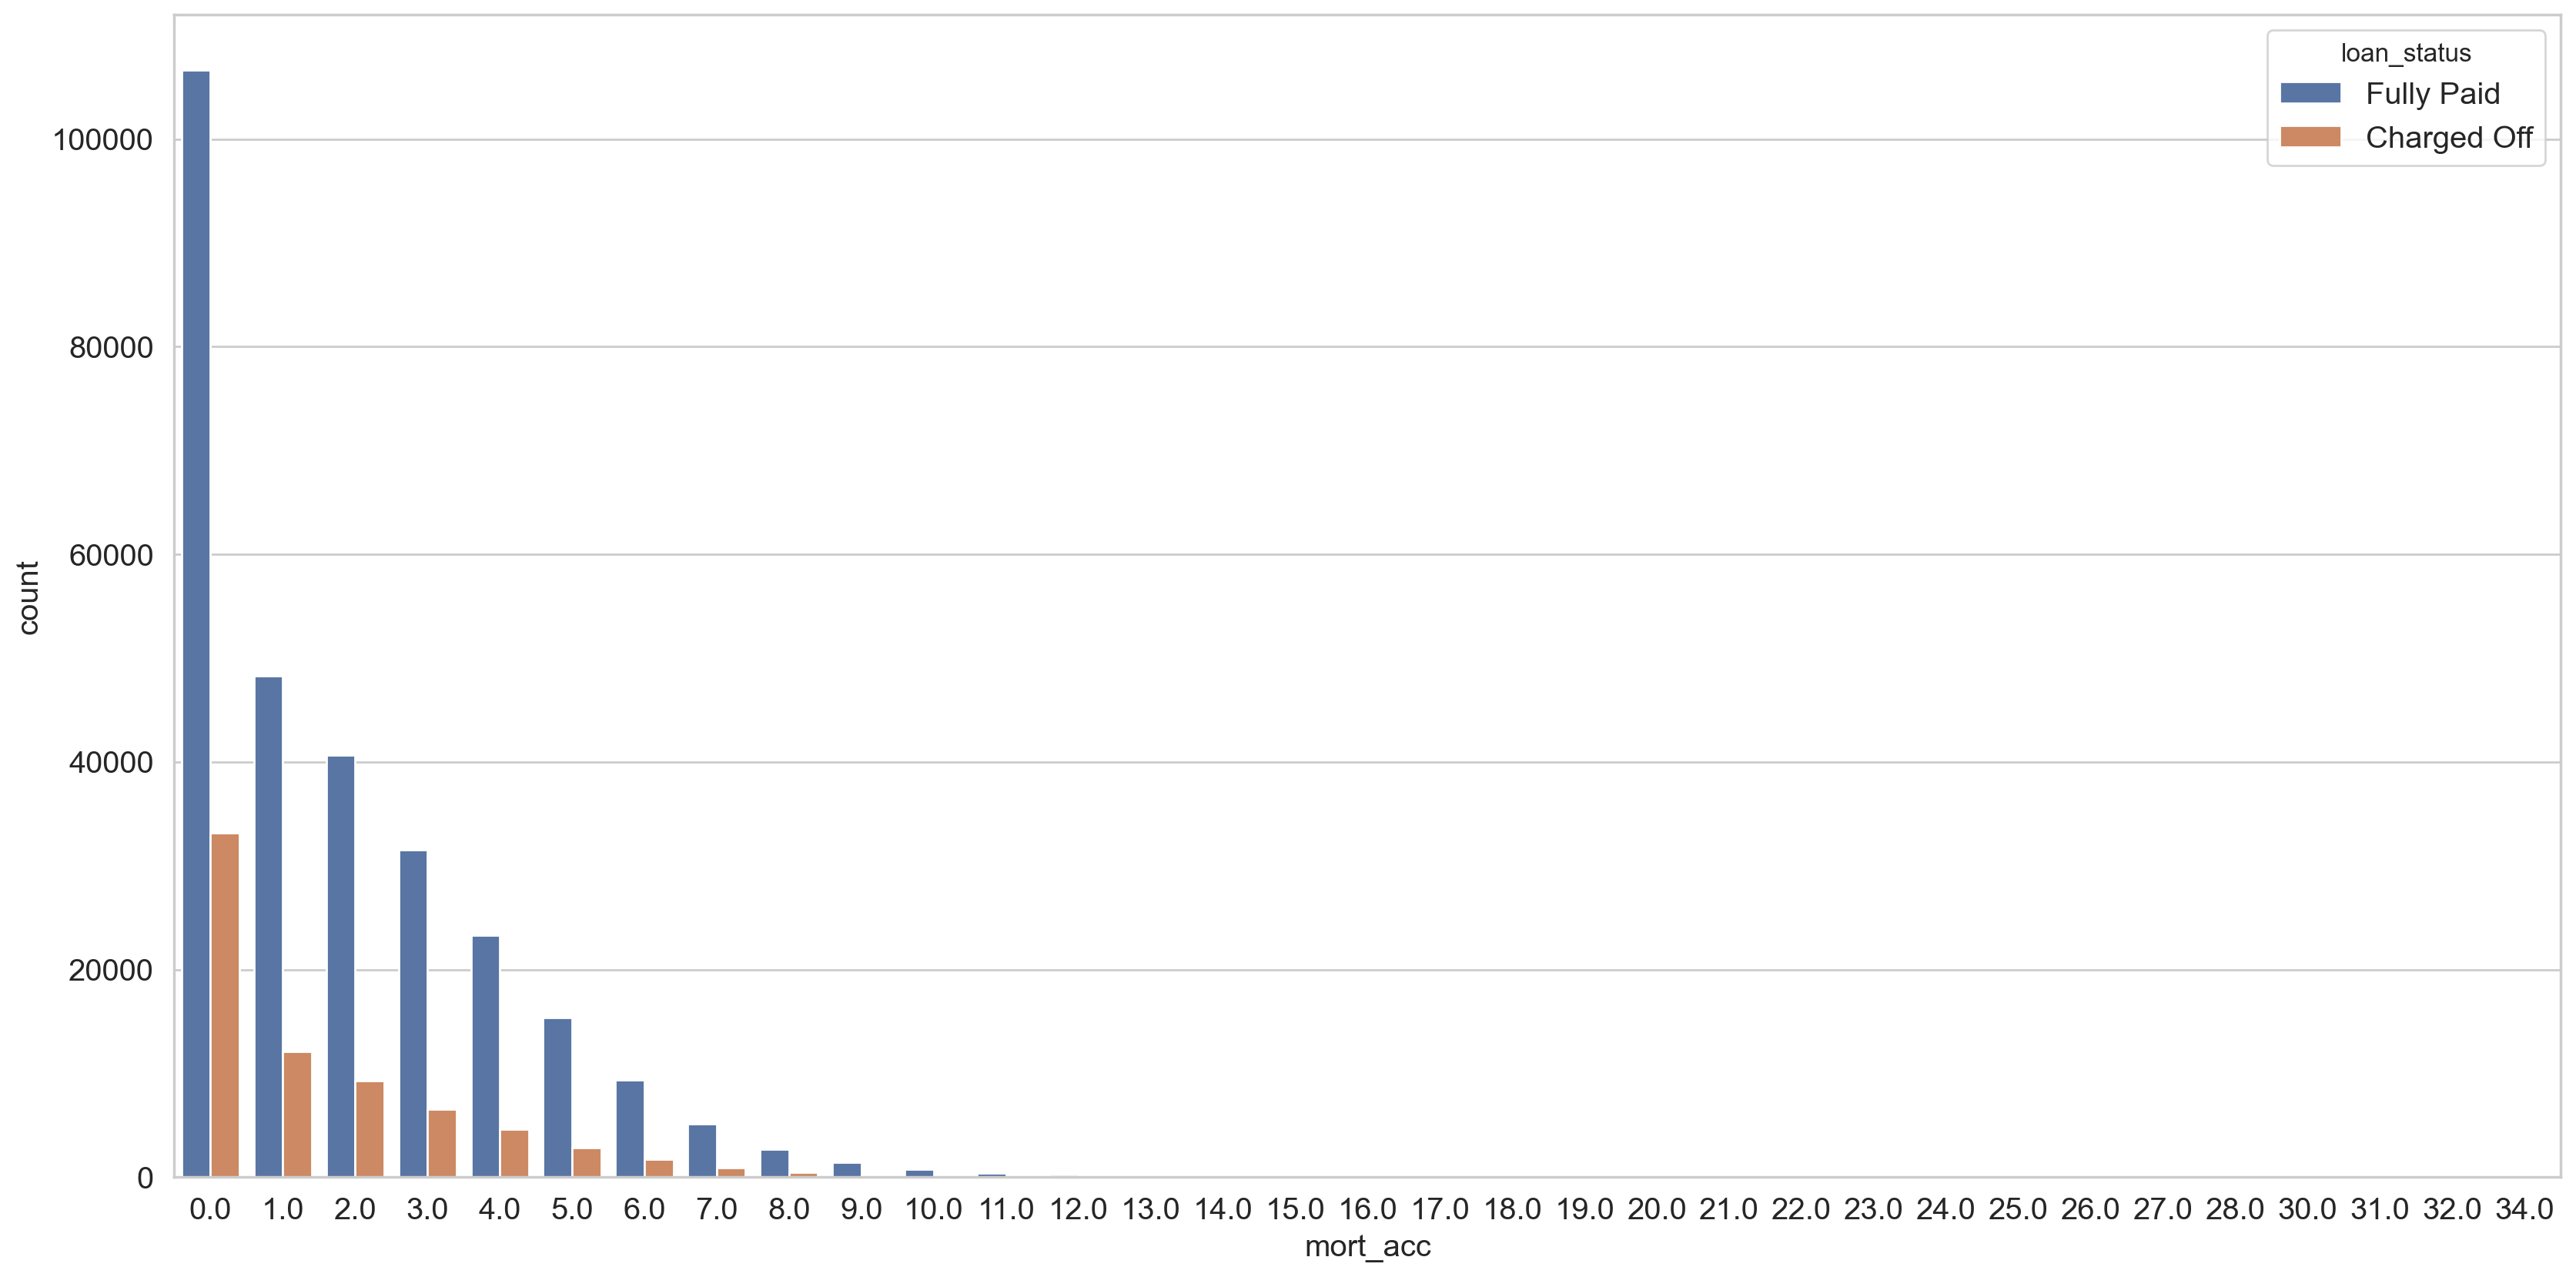

----------------------------------------------------------------------------------------------------


In [29]:
describe_cat_column('mort_acc')

pub_rec_bankruptcies
----------------------------------------------------------------------------------------------------
Unique values of pub_rec_bankruptcies are :  [0.0, 1.0, 2.0, 3.0, nan, 4.0, 5.0, 6.0, 7.0, 8.0]
----------------------------------------------------------------------------------------------------
pub_rec_bankruptcies
0.0    350380
1.0     42790
2.0      1847
3.0       351
4.0        82
5.0        32
6.0         7
7.0         4
8.0         2
Name: count, dtype: int64


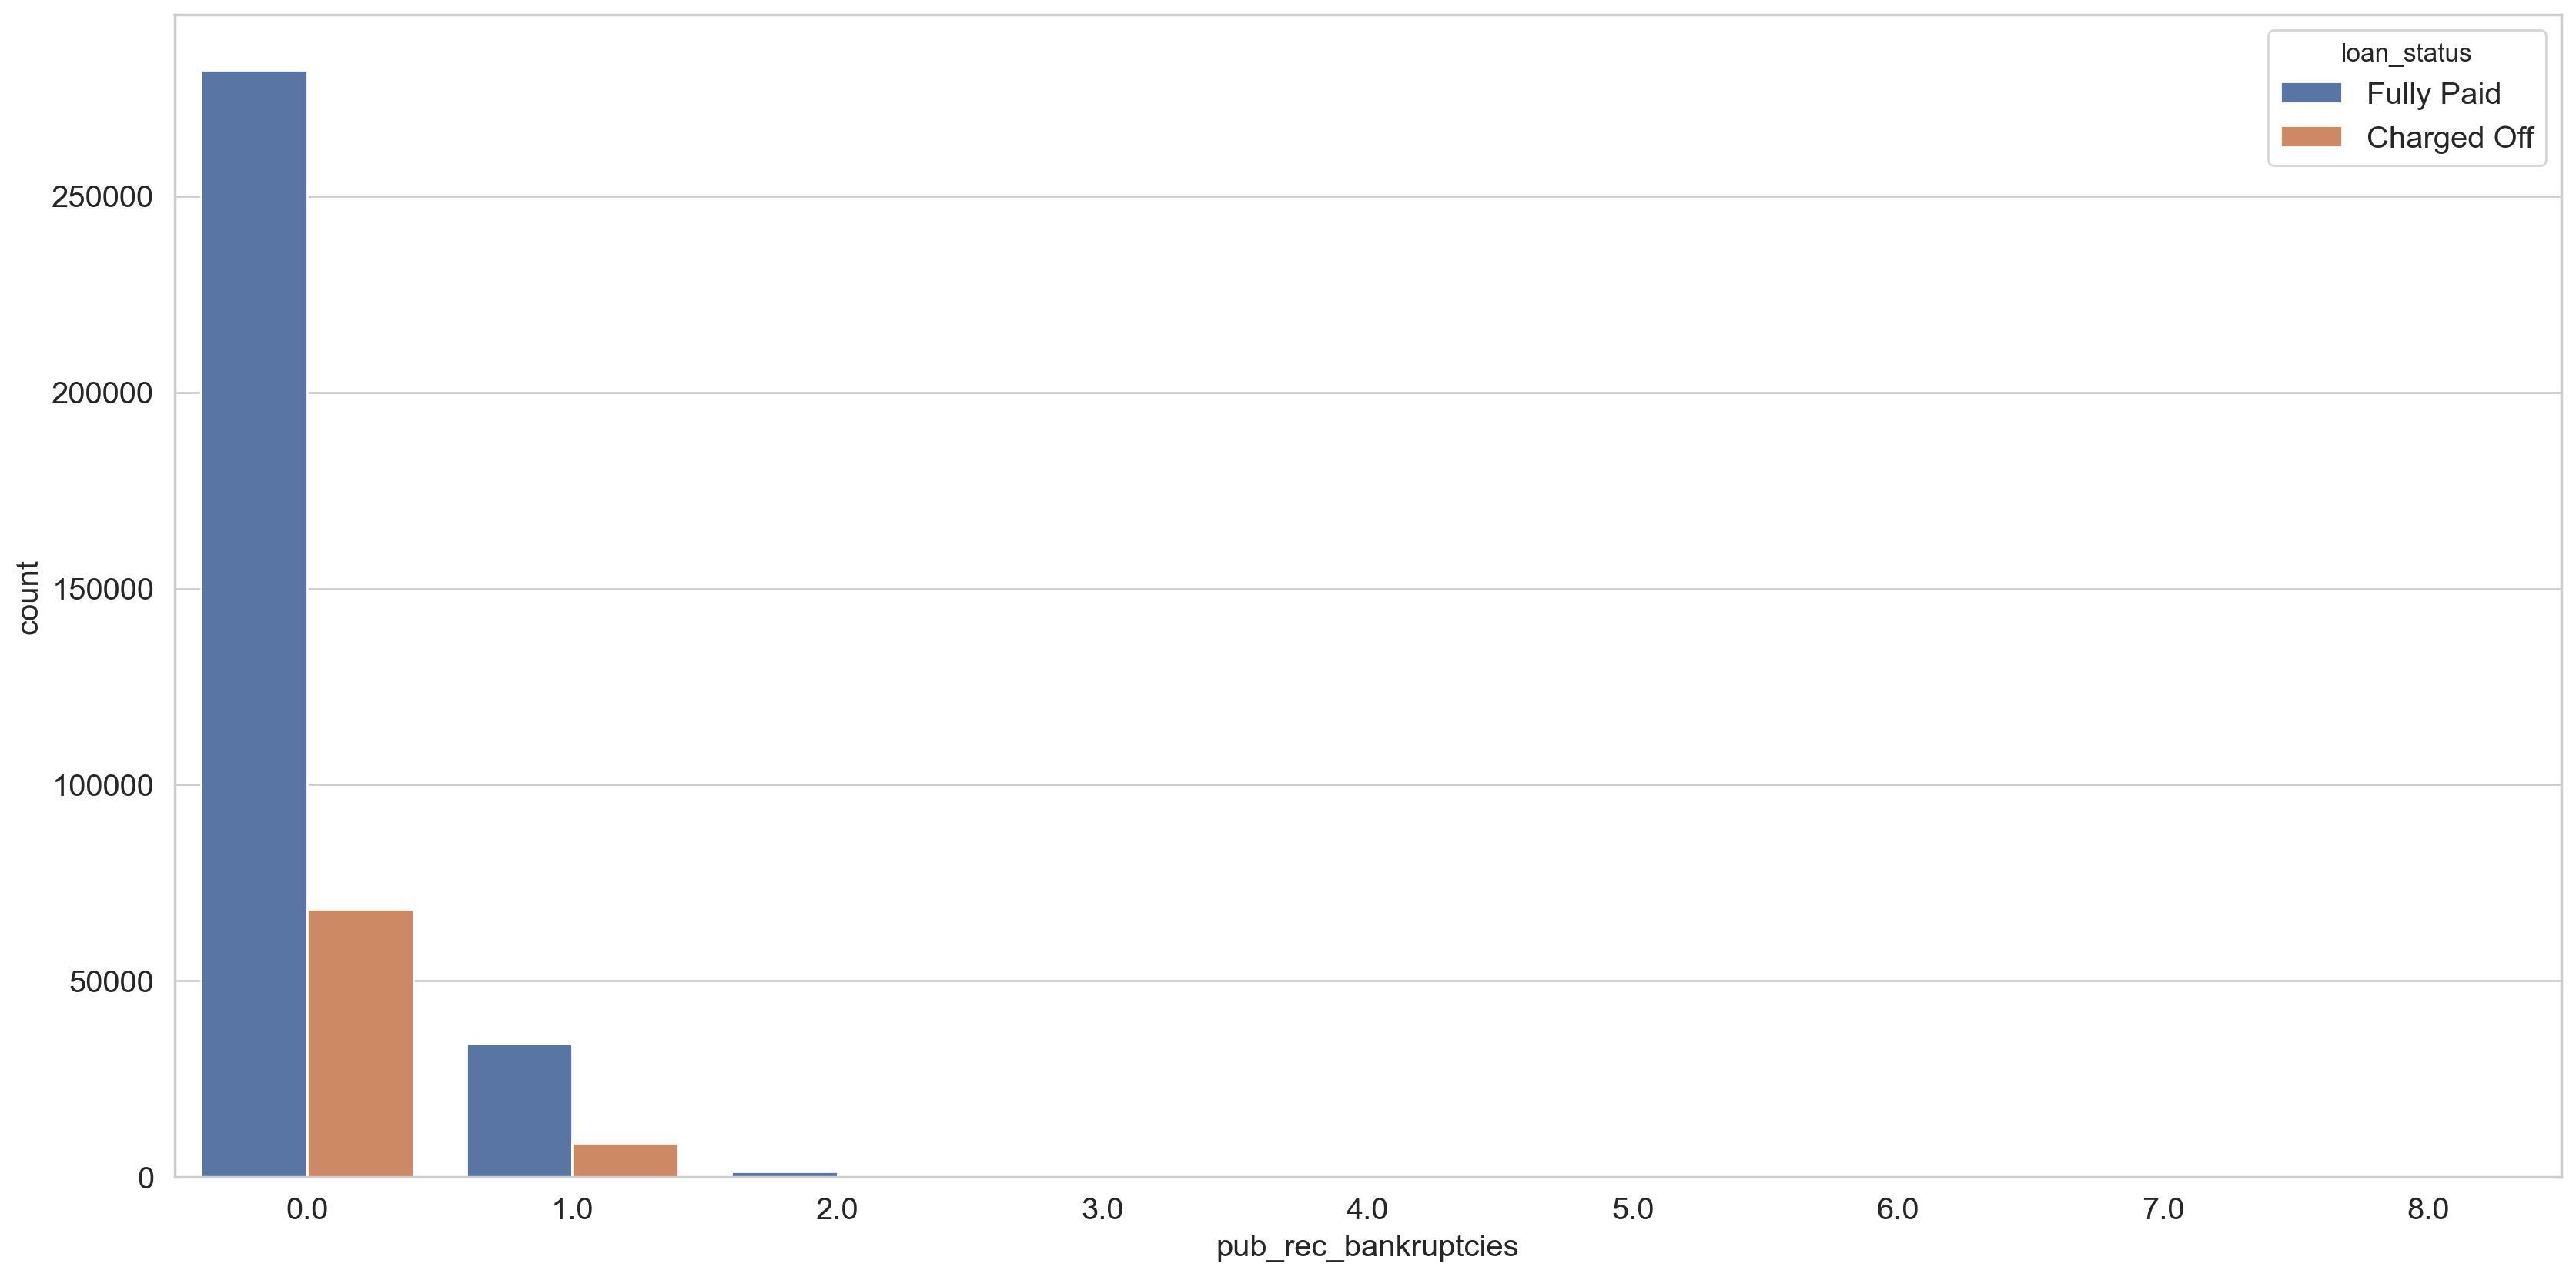

----------------------------------------------------------------------------------------------------


In [30]:
describe_cat_column('pub_rec_bankruptcies')

In [31]:
# Below are high outlier columns
# We dont want to delete these records since someone whos taken a loan for the first time 
#   may have low bankruptucy record
# Flagging anything more than 0 as 1

def pub_rec(number):
    if number == 0.0:
        return 0
    else:
        return 1
    
def mort_acc(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number
    
    
def pub_rec_bankruptcies(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number

In [32]:
df['pub_rec']=df.pub_rec.apply(pub_rec)
df['mort_acc']=df.mort_acc.apply(mort_acc)
df['pub_rec_bankruptcies']=df.pub_rec_bankruptcies.apply(pub_rec_bankruptcies)

<Axes: xlabel='pub_rec_bankruptcies', ylabel='count'>

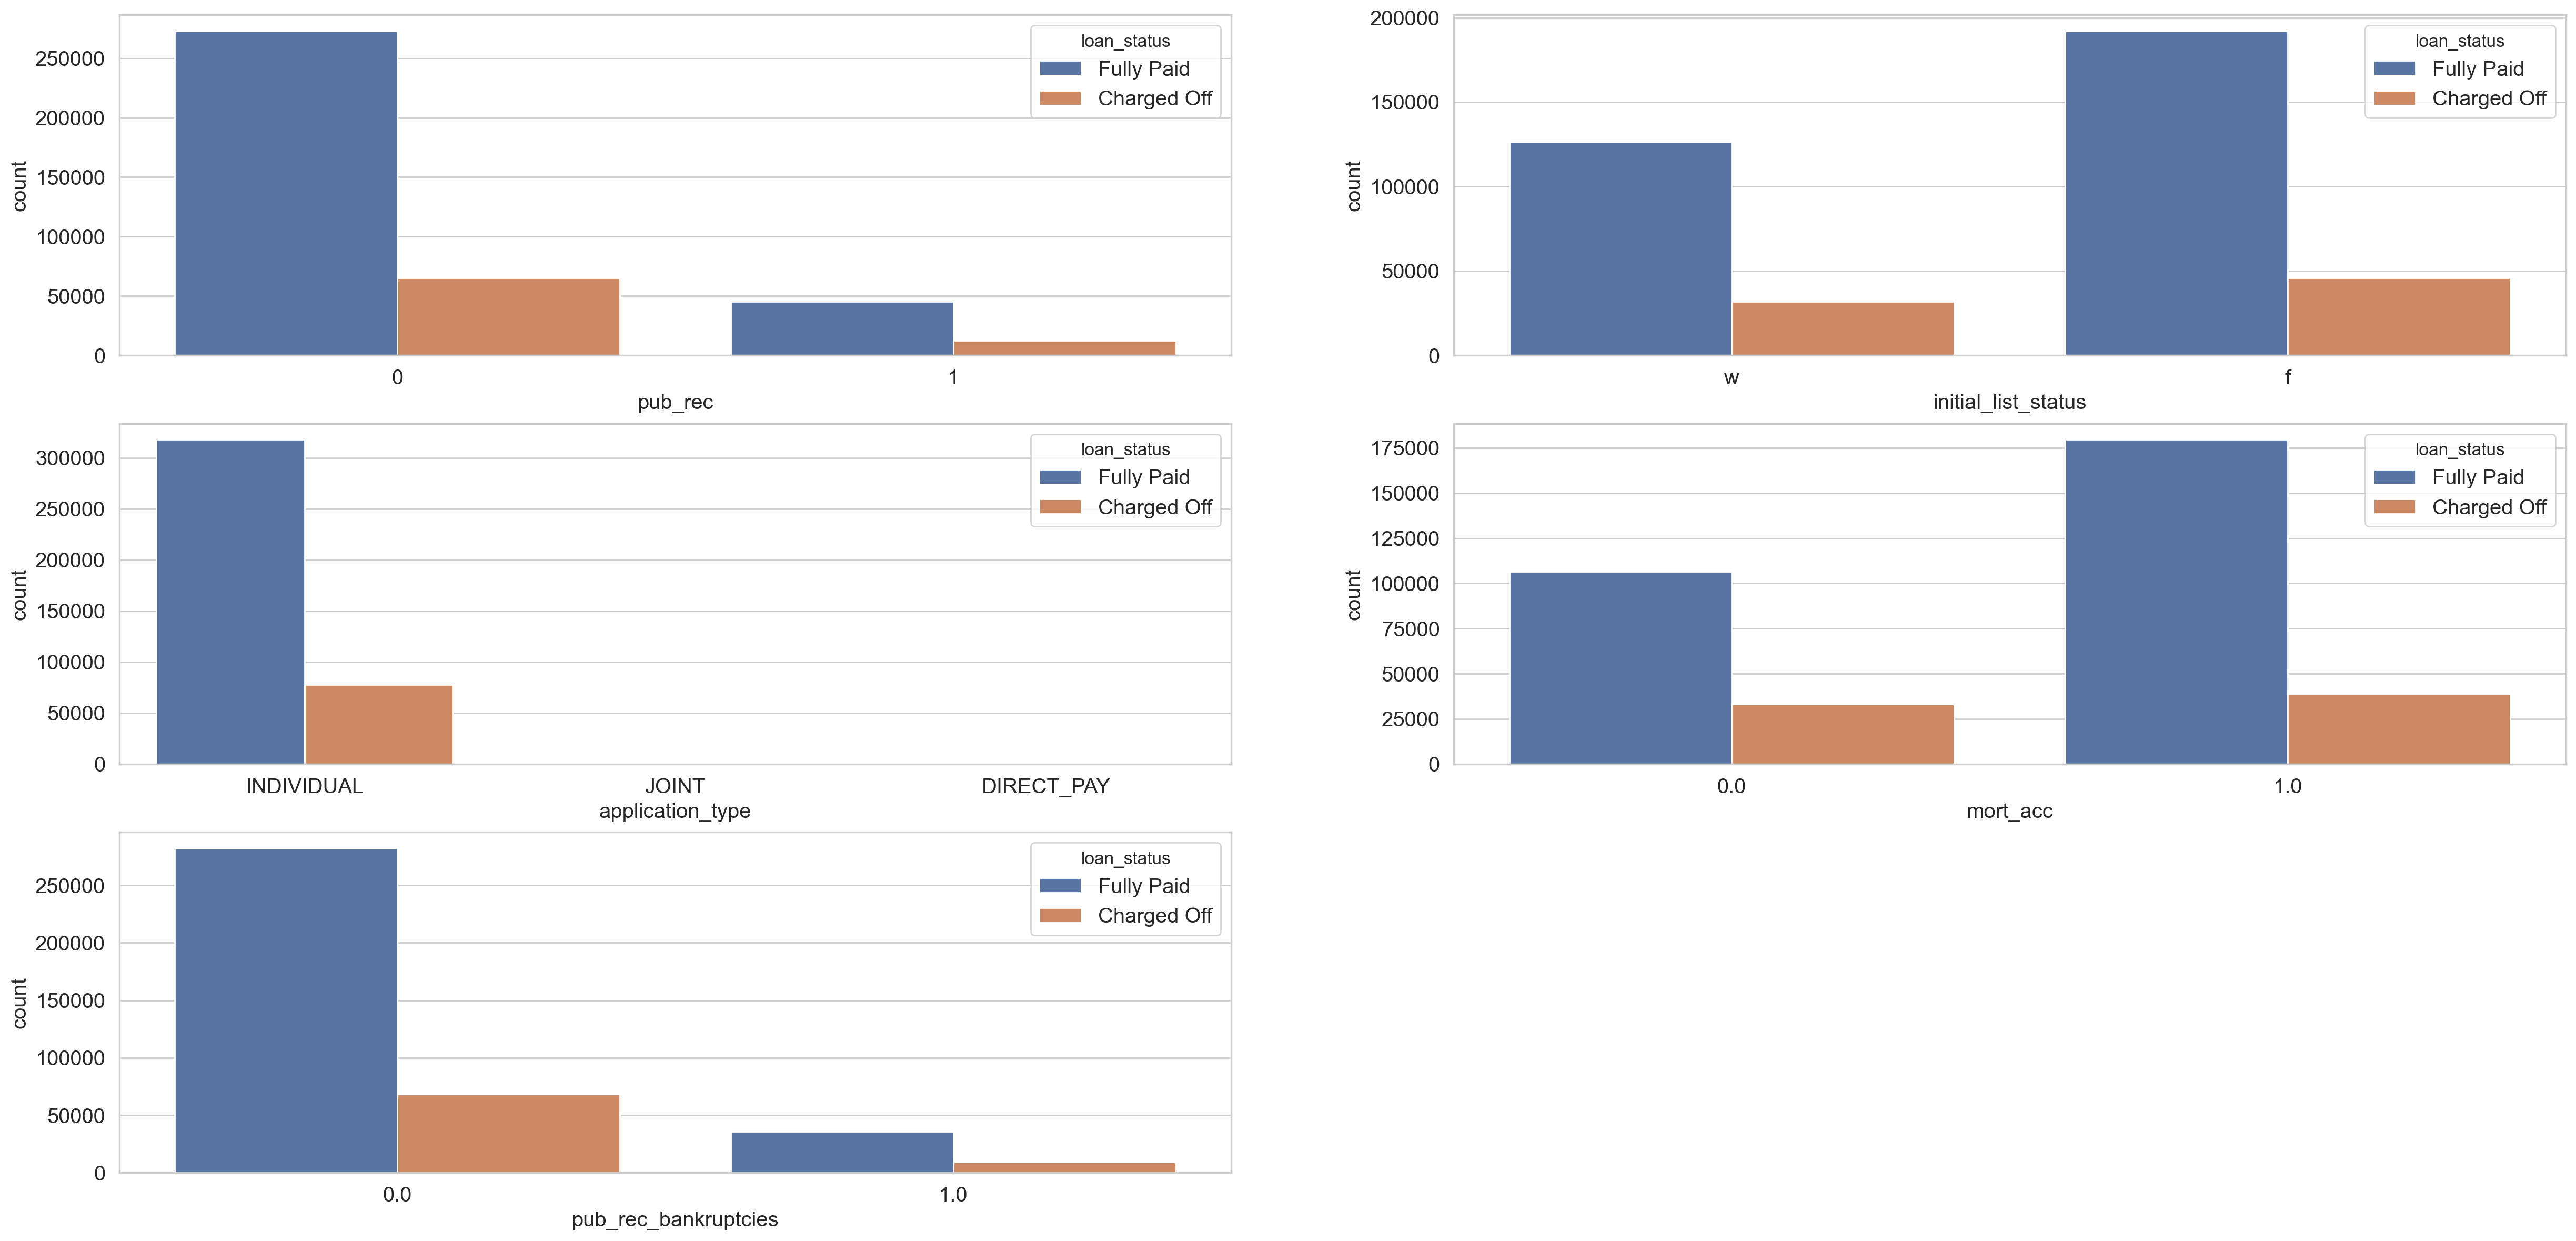

In [33]:
plt.figure(figsize=(30, 30),dpi = 200)

plt.subplot(6,2,1)
sns.countplot(x='pub_rec',data=df,hue='loan_status')

plt.subplot(6,2,2)
sns.countplot(x='initial_list_status',data=df,hue='loan_status')

plt.subplot(6,2,3)
sns.countplot(x='application_type',data=df,hue='loan_status')

plt.subplot(6,2,4)
sns.countplot(x='mort_acc',data=df,hue='loan_status')

plt.subplot(6,2,5)
sns.countplot(x='pub_rec_bankruptcies',data=df,hue='loan_status')

In [34]:
# Mapping of target variable 
df['loan_status']=df.loan_status.map({'Fully Paid':0, 'Charged Off':1})

In [35]:
df.isnull().sum()/len(df)*100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443401
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                9.543469
pub_rec_bankruptcies    0.135091
address                 0.000000
dtype: float64

In [36]:
# Mean Target Imputaion

In [37]:
cols = df.select_dtypes(include=[np.number]).columns.to_list()
df[cols].groupby(by='total_acc').mean()

,loan_amnt,int_rate,annual_inc,loan_status,dti,open_acc,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies
total_acc,,,,,,,,,,,
2.0,6672.222222,15.801111,64277.777778,0.222222,2.279444,1.611111,0.000000,2860.166667,53.527778,0.000000,0.000000
3.0,6042.966361,15.615566,41270.753884,0.220183,6.502813,2.611621,0.033639,3382.807339,49.991022,0.046243,0.015480
4.0,7587.399031,15.069491,42426.565969,0.214055,8.411963,3.324717,0.033118,4874.231826,58.477400,0.062140,0.019672
5.0,7845.734714,14.917564,44394.098003,0.203156,10.118328,3.921598,0.055720,5475.253452,56.890311,0.090789,0.039187
6.0,8529.019843,14.651752,48470.001156,0.215874,11.222542,4.511119,0.076634,6546.374957,57.812483,0.121983,0.050947
...,...,...,...,...,...,...,...,...,...,...,...
124.0,23200.000000,17.860000,66000.000000,1.000000,14.040000,43.000000,0.000000,25497.000000,75.400000,1.000000,0.000000
129.0,25000.000000,7.890000,200000.000000,0.000000,8.900000,48.000000,0.000000,27659.000000,8.300000,1.000000,0.000000
135.0,24000.000000,15.410000,82000.000000,0.000000,33.850000,57.000000,0.000000,35715.000000,50.800000,1.000000,0.000000


In [38]:
total_acc_avg=df[cols].groupby(by='total_acc').mean().mort_acc
# saving mean of mort_acc according to total_acc_avg

In [39]:
def fill_mort_acc(total_acc,mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc].round()
    else:
        return mort_acc

In [40]:
df['mort_acc']=df.apply(lambda x: fill_mort_acc(x['total_acc'],x['mort_acc']),axis=1)

In [41]:
df.isnull().sum()/len(df)*100

loan_amnt               0.000000
term                    0.000000
int_rate                0.000000
grade                   0.000000
sub_grade               0.000000
emp_title               5.789208
emp_length              4.621115
home_ownership          0.000000
annual_inc              0.000000
verification_status     0.000000
issue_d                 0.000000
loan_status             0.000000
purpose                 0.000000
title                   0.443401
dti                     0.000000
earliest_cr_line        0.000000
open_acc                0.000000
pub_rec                 0.000000
revol_bal               0.000000
revol_util              0.069692
total_acc               0.000000
initial_list_status     0.000000
application_type        0.000000
mort_acc                0.000000
pub_rec_bankruptcies    0.135091
address                 0.000000
dtype: float64

In [42]:
# Current no. of rows
df.shape

(396030, 26)

In [43]:
# Dropping rows with null values
df.dropna(inplace=True)

In [44]:
# Remaining no. of rows
df.shape

(370621, 26)

In [45]:
# Outlier Detection & Treatment

In [46]:
numerical_data=df.select_dtypes(include='number')
num_cols=numerical_data.columns
len(num_cols)

12

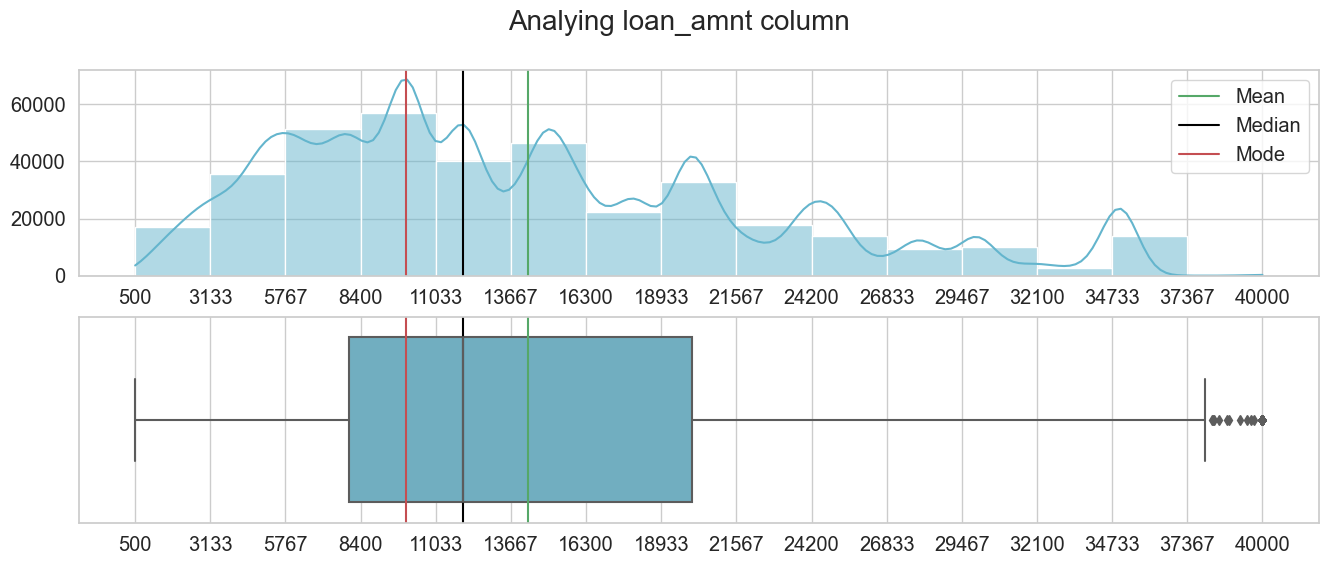

----------------------------------------------------------------------------------------------------
count    370621.000000
mean      14250.184488
std        8357.785097
min         500.000000
25%        8000.000000
50%       12000.000000
75%       20000.000000
max       40000.000000
----------------------------------------------------------------------------------------------------
No outliers on left extreme
----------------------------------------------------------------------------------------------------

Outliers on right extreme:-

Total 179 outliers which are greater than 38000.0
----------------------------------------------------------------------------------------------------


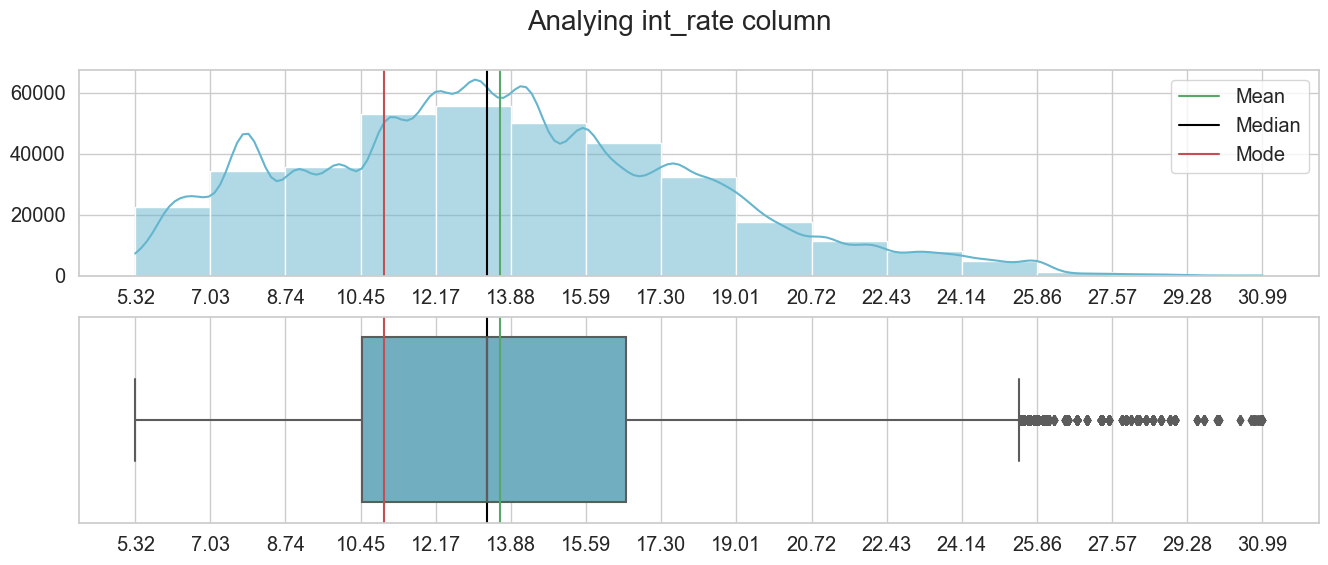

----------------------------------------------------------------------------------------------------
count    370621.000000
mean         13.637437
std           4.471626
min           5.320000
25%          10.490000
50%          13.330000
75%          16.490000
max          30.990000
----------------------------------------------------------------------------------------------------
No outliers on left extreme
----------------------------------------------------------------------------------------------------

Outliers on right extreme:-

Total 3526 outliers which are greater than 25.489999999999995
----------------------------------------------------------------------------------------------------


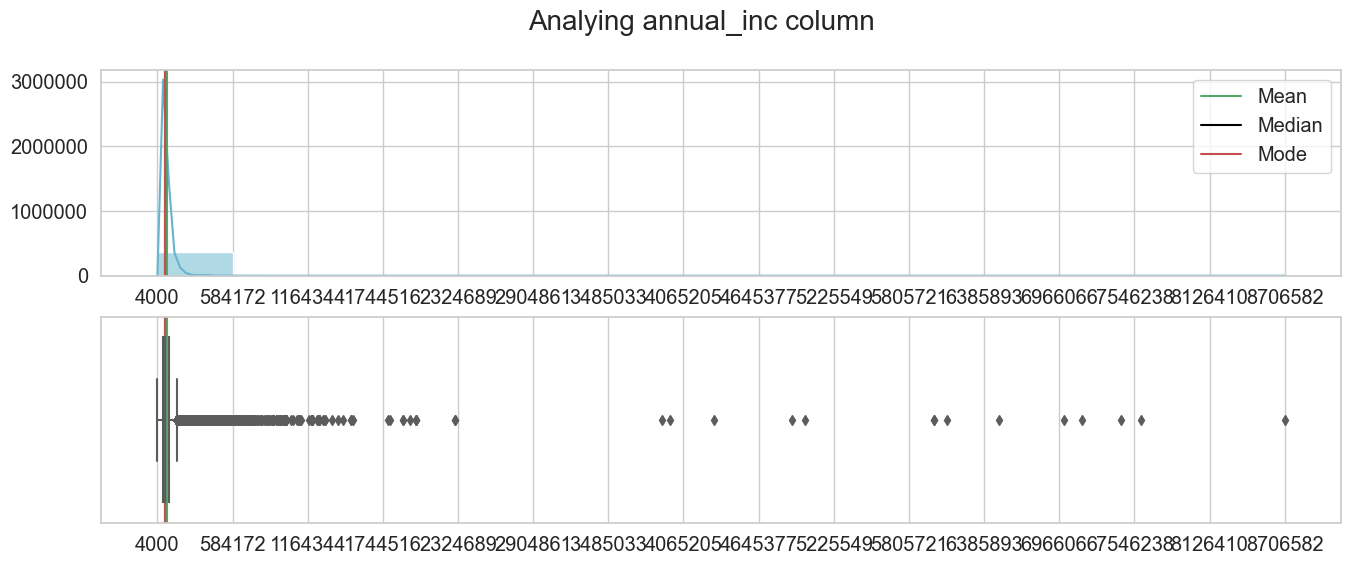

----------------------------------------------------------------------------------------------------
count    3.706210e+05
mean     7.518787e+04
std      6.209026e+04
min      4.000000e+03
25%      4.600000e+04
50%      6.500000e+04
75%      9.000000e+04
max      8.706582e+06
----------------------------------------------------------------------------------------------------
No outliers on left extreme
----------------------------------------------------------------------------------------------------

Outliers on right extreme:-

Total 16033 outliers which are greater than 156000.0
----------------------------------------------------------------------------------------------------


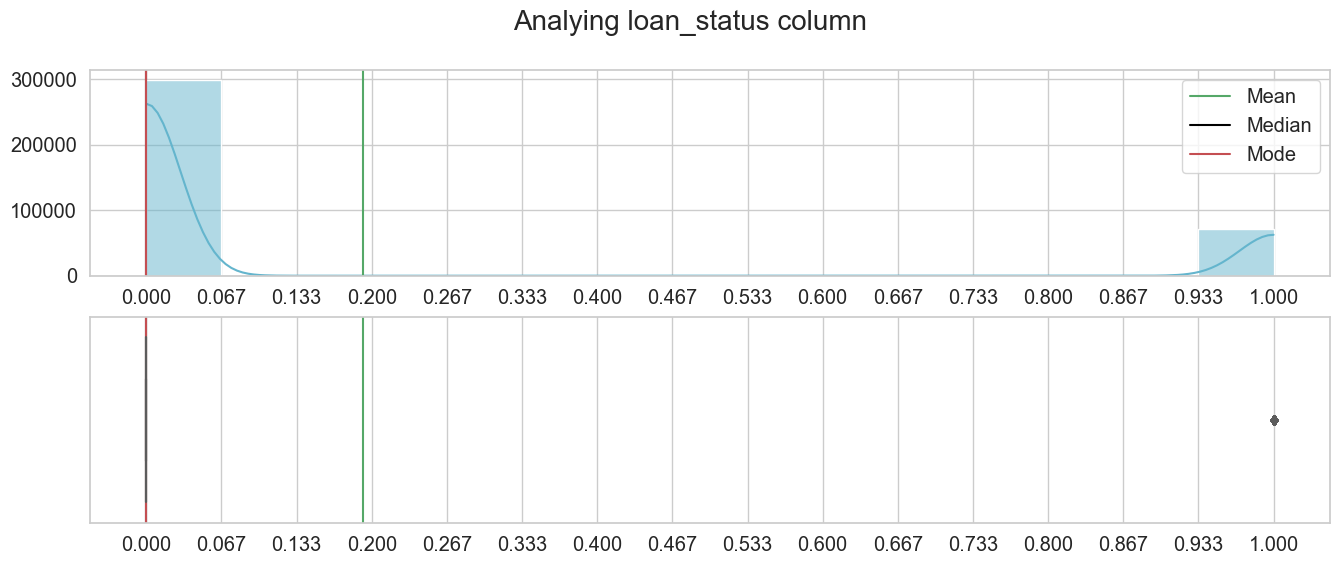

----------------------------------------------------------------------------------------------------
count    370621.000000
mean          0.192266
std           0.394082
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
----------------------------------------------------------------------------------------------------
No outliers on left extreme
----------------------------------------------------------------------------------------------------

Outliers on right extreme:-

Total 71258 outliers which are greater than 0.0
----------------------------------------------------------------------------------------------------


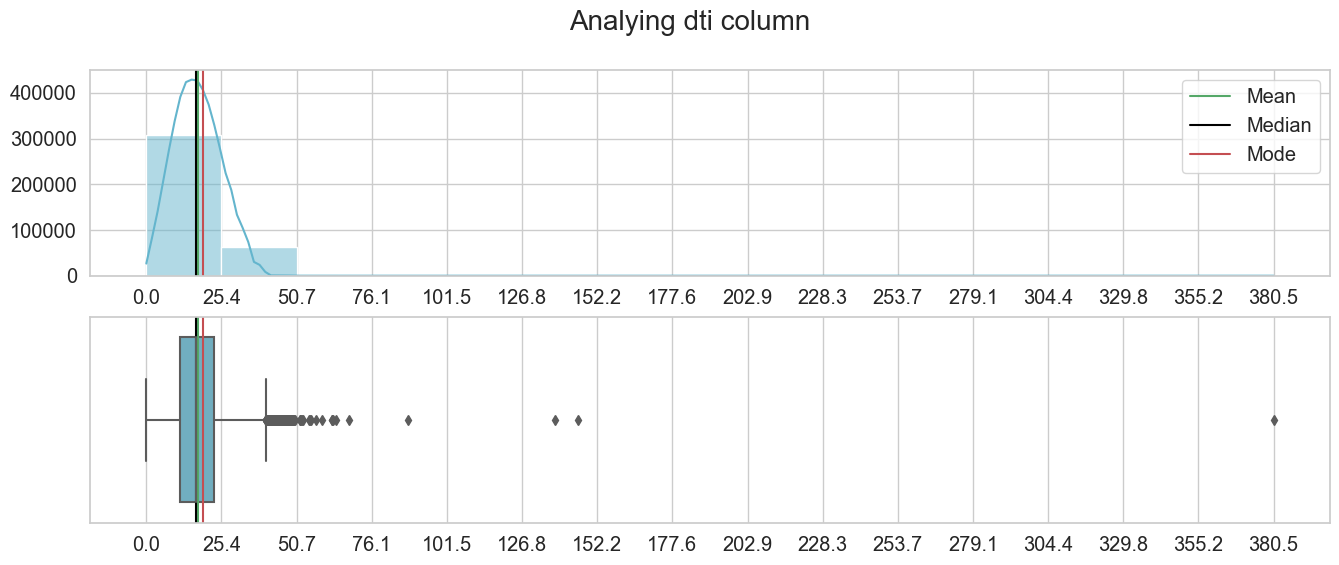

----------------------------------------------------------------------------------------------------
count    370621.000000
mean         17.337372
std           8.103813
min           0.000000
25%          11.320000
50%          16.900000
75%          22.930000
max         380.530000
----------------------------------------------------------------------------------------------------
No outliers on left extreme
----------------------------------------------------------------------------------------------------

Outliers on right extreme:-

Total 226 outliers which are greater than 40.345
----------------------------------------------------------------------------------------------------


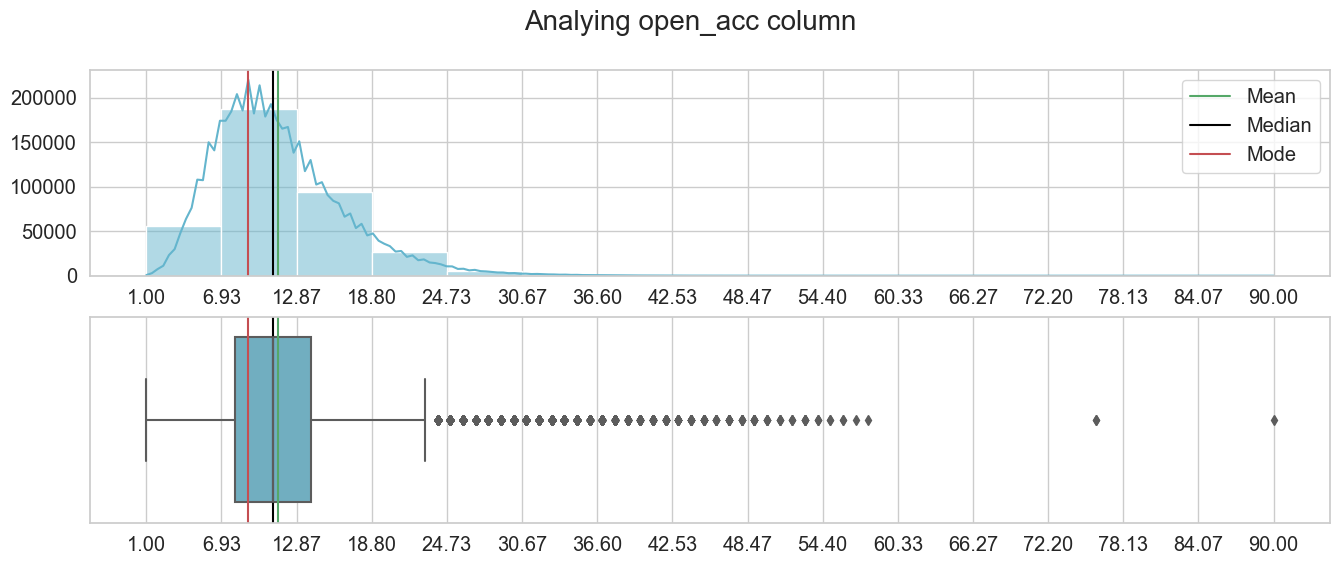

----------------------------------------------------------------------------------------------------
count    370621.000000
mean         11.393337
std           5.146309
min           1.000000
25%           8.000000
50%          11.000000
75%          14.000000
max          90.000000
----------------------------------------------------------------------------------------------------
No outliers on left extreme
----------------------------------------------------------------------------------------------------

Outliers on right extreme:-

Total 9869 outliers which are greater than 23.0
----------------------------------------------------------------------------------------------------


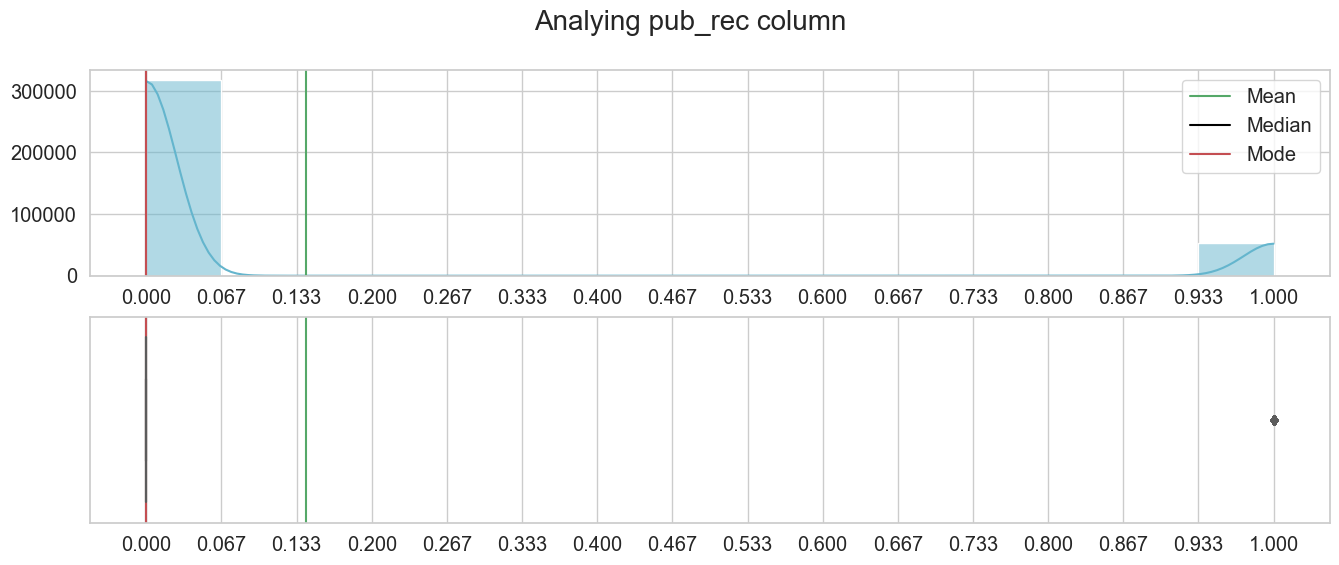

----------------------------------------------------------------------------------------------------
count    370621.000000
mean          0.141263
std           0.348293
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
----------------------------------------------------------------------------------------------------
No outliers on left extreme
----------------------------------------------------------------------------------------------------

Outliers on right extreme:-

Total 52355 outliers which are greater than 0.0
----------------------------------------------------------------------------------------------------


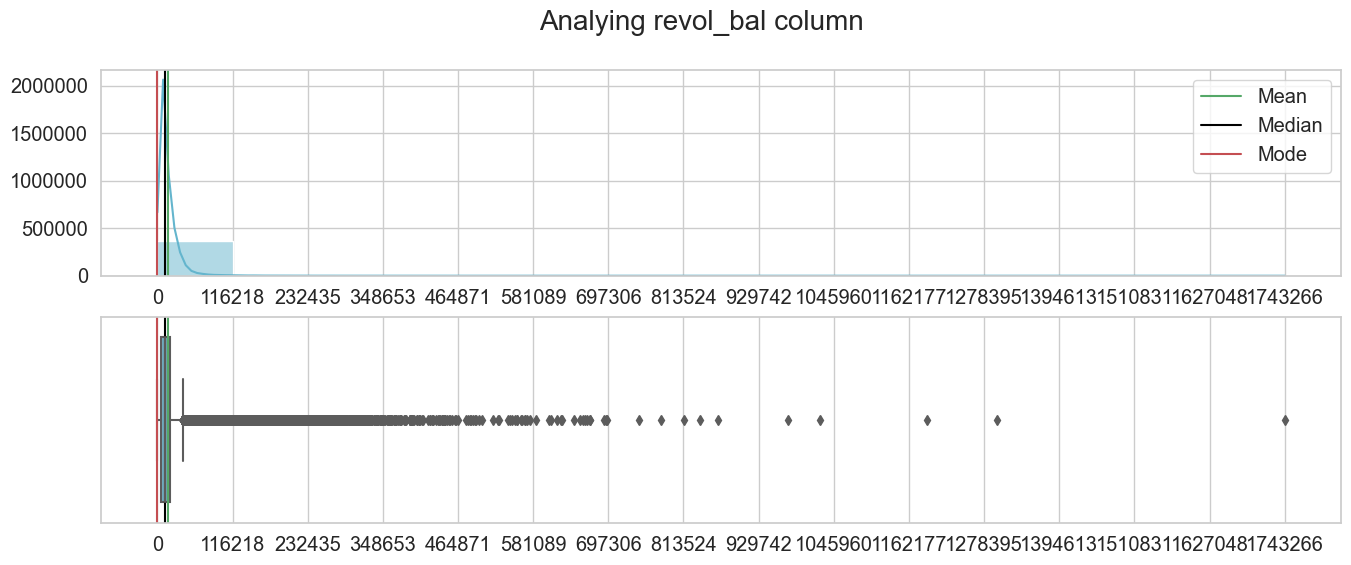

----------------------------------------------------------------------------------------------------
count    3.706210e+05
mean     1.595062e+04
std      2.053893e+04
min      0.000000e+00
25%      6.115000e+03
50%      1.130300e+04
75%      1.976700e+04
max      1.743266e+06
----------------------------------------------------------------------------------------------------
No outliers on left extreme
----------------------------------------------------------------------------------------------------

Outliers on right extreme:-

Total 19805 outliers which are greater than 40245.0
----------------------------------------------------------------------------------------------------


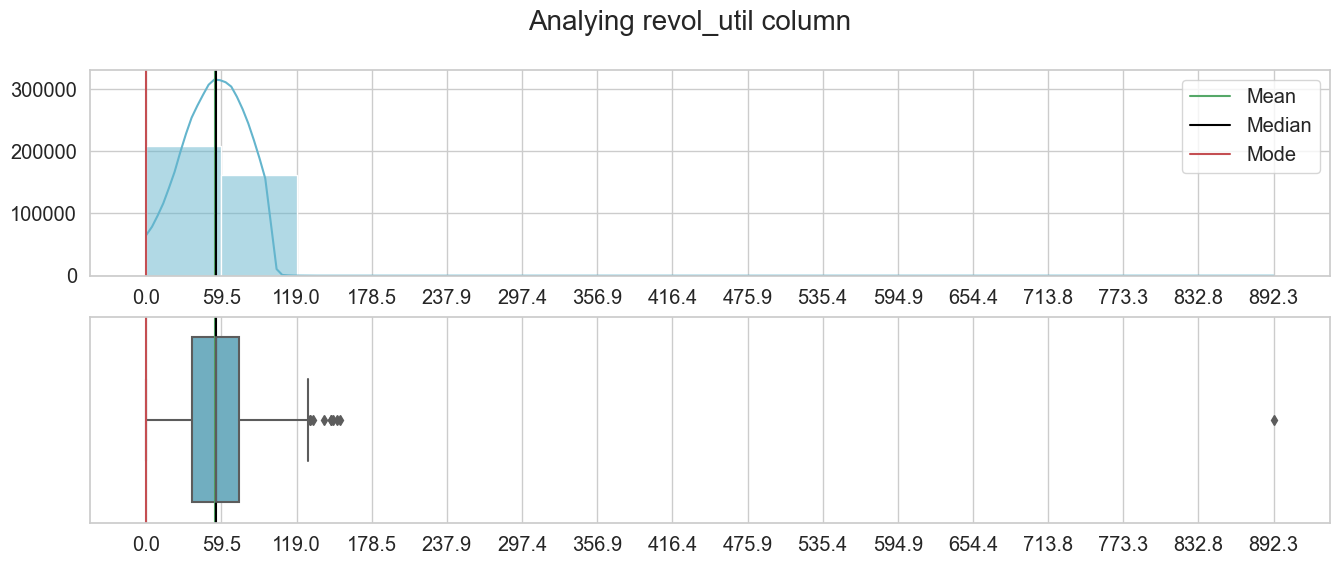

----------------------------------------------------------------------------------------------------
count    370621.000000
mean         53.991222
std          24.390010
min           0.000000
25%          36.100000
50%          55.000000
75%          73.000000
max         892.300000
----------------------------------------------------------------------------------------------------
No outliers on left extreme
----------------------------------------------------------------------------------------------------

Outliers on right extreme:-

Total 10 outliers which are greater than 128.35
----------------------------------------------------------------------------------------------------


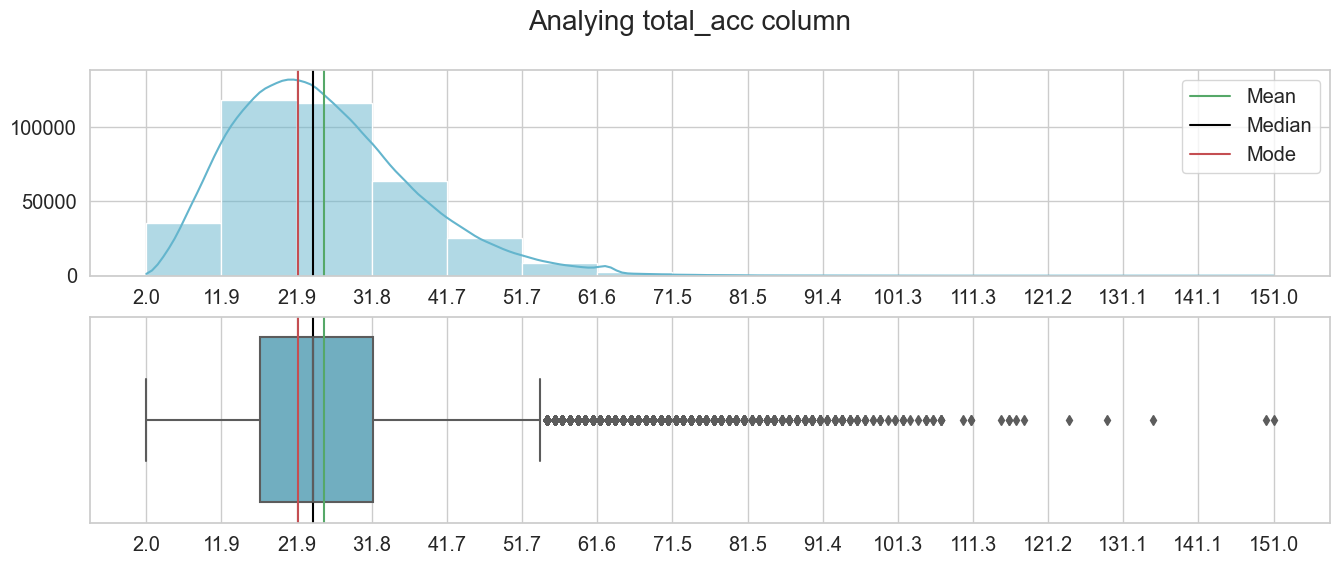

----------------------------------------------------------------------------------------------------
count    370621.000000
mean         25.518503
std          11.886703
min           2.000000
25%          17.000000
50%          24.000000
75%          32.000000
max         151.000000
----------------------------------------------------------------------------------------------------
No outliers on left extreme
----------------------------------------------------------------------------------------------------

Outliers on right extreme:-

Total 8052 outliers which are greater than 54.5
----------------------------------------------------------------------------------------------------


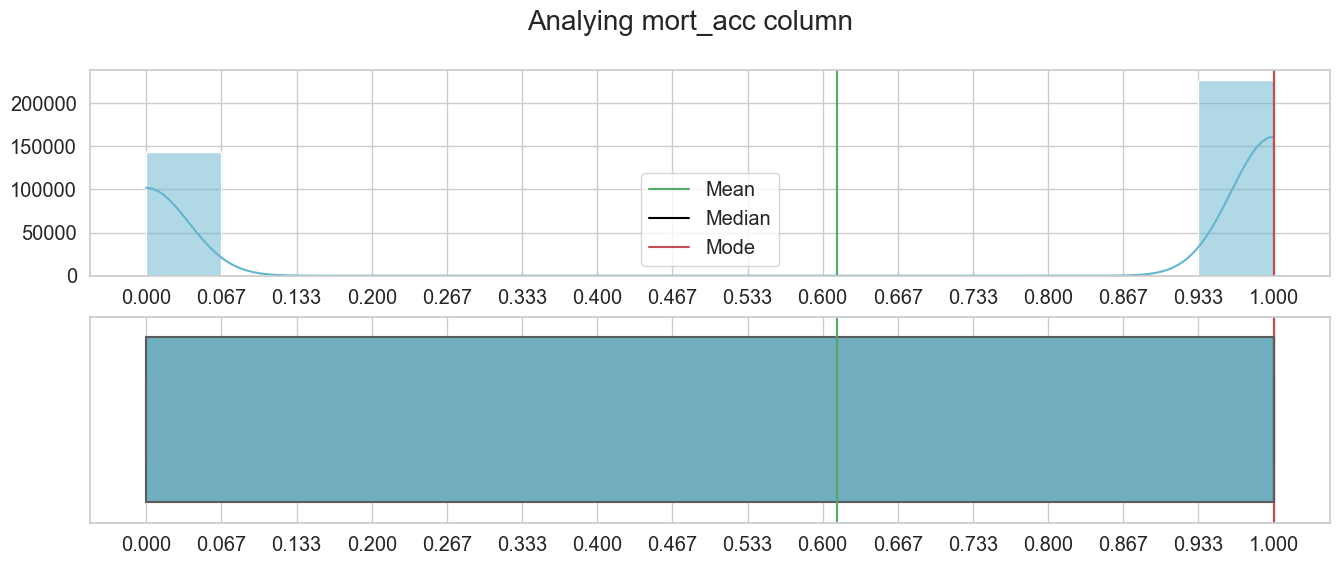

----------------------------------------------------------------------------------------------------
count    370621.000000
mean          0.612469
std           0.487187
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
----------------------------------------------------------------------------------------------------
No outliers on left extreme
----------------------------------------------------------------------------------------------------
No outliers on right extreme
----------------------------------------------------------------------------------------------------


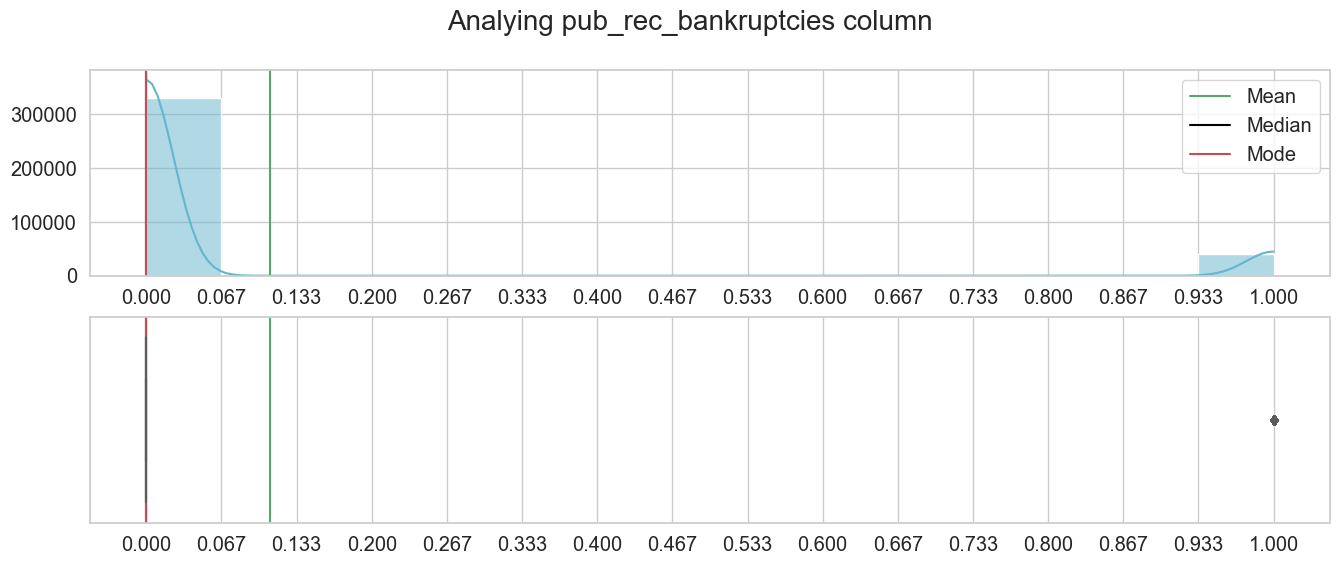

----------------------------------------------------------------------------------------------------
count    370621.000000
mean          0.109921
std           0.312792
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
----------------------------------------------------------------------------------------------------
No outliers on left extreme
----------------------------------------------------------------------------------------------------

Outliers on right extreme:-

Total 40739 outliers which are greater than 0.0
----------------------------------------------------------------------------------------------------


In [47]:
def box_plot(col):
    plt.figure(figsize=(8,5))
    sns.boxplot(x=data[col])
    plt.title('Boxplot')
    plt.show()
    
for col in num_cols:
    draw_plot_numerical(col, 15)
    describe_and_find_outliers(col)

In [48]:
for col in num_cols:
    mean=df[col].mean()
    std=df[col].std()
    
    upper_limit=mean+3*std
    lower_limit=mean-3*std
    
    df=df[(df[col]<upper_limit) & (df[col]>lower_limit)]
    
df.shape

(354518, 26)

In [49]:
# Data Preprocesing

In [50]:
# Term
df.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [51]:
term_values={' 36 months': 36, ' 60 months':60}
df['term'] = df.term.map(term_values)

In [52]:
# Initial List Status
df['initial_list_status'].unique()

array(['w', 'f'], dtype=object)

In [53]:
list_status = {'w': 0, 'f': 1}
df['initial_list_status'] = df.initial_list_status.map(list_status)

In [54]:
# Let's fetch ZIP from address and then drop the remaining details -
df['zip_code'] = df.address.apply(lambda x: x[-5:])

In [55]:
df['zip_code'].value_counts(normalize=True)*100

zip_code
70466    14.382062
30723    14.277413
22690    14.268387
48052    14.127068
00813    11.610130
29597    11.537073
05113    11.516764
93700     2.774753
11650     2.772779
86630     2.733571
Name: proportion, dtype: float64

In [56]:
# Dropping some variables which we can let go for now 
df.drop(columns=['issue_d', 'emp_title', 'title', 'sub_grade',
                   'address', 'earliest_cr_line', 'emp_length'], 
                   axis=1, inplace=True)

In [57]:
# One-hot Encoding

In [58]:
dummies=['purpose', 'zip_code', 'grade', 'verification_status', 'application_type', 'home_ownership']
df=pd.get_dummies(df,columns=dummies,drop_first=True)

In [59]:
df.head()

,loan_amnt,term,int_rate,annual_inc,loan_status,dti,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,mort_acc,pub_rec_bankruptcies,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,zip_code_05113,zip_code_11650,zip_code_22690,zip_code_29597,zip_code_30723,zip_code_48052,zip_code_70466,zip_code_86630,zip_code_93700,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,verification_status_Source Verified,verification_status_Verified,application_type_INDIVIDUAL,application_type_JOINT,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
0,10000.0,36,11.44,117000.0,0,26.24,16.0,0,36369.0,41.8,25.0,0,0.0,0.0,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True
1,8000.0,36,11.99,65000.0,0,22.05,17.0,0,20131.0,53.3,27.0,1,1.0,0.0,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False
2,15600.0,36,10.49,43057.0,0,12.79,13.0,0,11987.0,92.2,26.0,1,0.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,True
3,7200.0,36,6.49,54000.0,0,2.60,6.0,0,5472.0,21.5,13.0,1,0.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True
4,24375.0,60,17.27,55000.0,1,33.95,13.0,0,24584.0,69.8,43.0,1,1.0,0.0,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,True,False,False,False,False


In [60]:
df.shape

(354518, 49)

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354518 entries, 0 to 396029
Data columns (total 49 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            354518 non-null  float64
 1   term                                 354518 non-null  int64  
 2   int_rate                             354518 non-null  float64
 3   annual_inc                           354518 non-null  float64
 4   loan_status                          354518 non-null  int64  
 5   dti                                  354518 non-null  float64
 6   open_acc                             354518 non-null  float64
 7   pub_rec                              354518 non-null  int64  
 8   revol_bal                            354518 non-null  float64
 9   revol_util                           354518 non-null  float64
 10  total_acc                            354518 non-null  float64
 11  initial_list_statu

In [62]:
X=df.drop('loan_status',axis=1)
y=df['loan_status']

In [63]:
X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=0.30,stratify=y,random_state=69)

In [64]:
print(X_train.shape)
print(X_test.shape)

(248162, 48)
(106356, 48)


In [65]:
# MinMaxScaler -
# For each value in a feature, MinMaxScaler subtracts the minimum value in the feature 
# and then divides by the range. The range is the difference between the original maximum and original minimum.

# MinMaxScaler preserves the shape of the original distribution. 
# It doesn’t meaningfully change the information embedded in the original data.

In [66]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [67]:
# Logistic Regression

In [68]:
logreg=LogisticRegression(max_iter=1000)
logreg.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [69]:
y_pred = logreg.predict(X_test)
print('Accuracy of Logistic Regression Classifier on test set: {:.3f}'.format(logreg.score(X_test, y_test)))

Accuracy of Logistic Regression Classifier on test set: 0.890


In [70]:
# Confusion Matrix

In [71]:
cm=confusion_matrix(y_test,y_pred)
print(cm)

[[85383   505]
 [11143  9325]]


In [72]:
# Classification Report

In [73]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.94     85888
           1       0.95      0.46      0.62     20468

    accuracy                           0.89    106356
   macro avg       0.92      0.72      0.78    106356
weighted avg       0.90      0.89      0.87    106356



In [74]:
# ROC Curve

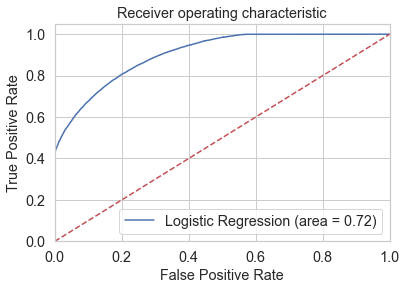

In [75]:
logit_roc_auc=roc_auc_score(y_test,logreg.predict(X_test))
fpr,tpr,thresholds=roc_curve(y_test,logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

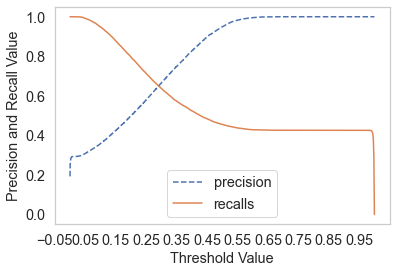

In [76]:
def precission_recall_curve_plot(y_test,pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test,pred_proba_c1)
    
    threshold_boundary = thresholds.shape[0]
    #plot precision
    plt.plot(thresholds,precisions[0:threshold_boundary],linestyle='--',label='precision')
    #plot recall
    plt.plot(thresholds,recalls[0:threshold_boundary],label='recalls')
    
    start,end=plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    
    plt.xlabel('Threshold Value')
    plt.ylabel('Precision and Recall Value')
    plt.legend()
    plt.grid()
    plt.show()

precission_recall_curve_plot(y_test,logreg.predict_proba(X_test)[:,1])

In [77]:
# Multicollinearity check using Variance Inflation Factor (VIF)

In [78]:
X.isnull().sum()

loan_amnt                              0
term                                   0
int_rate                               0
annual_inc                             0
dti                                    0
open_acc                               0
pub_rec                                0
revol_bal                              0
revol_util                             0
total_acc                              0
initial_list_status                    0
mort_acc                               0
pub_rec_bankruptcies                   0
purpose_credit_card                    0
purpose_debt_consolidation             0
purpose_educational                    0
purpose_home_improvement               0
purpose_house                          0
purpose_major_purchase                 0
purpose_medical                        0
purpose_moving                         0
purpose_other                          0
purpose_renewable_energy               0
purpose_small_business                 0
purpose_vacation

In [79]:
def calc_vif(X):
    # Select only numeric columns
    X_numeric = X.select_dtypes(include=[np.number])
    
    # Calculating the VIF
    vif=pd.DataFrame()
    vif['Feature']=X_numeric.columns
    vif['VIF']=[variance_inflation_factor(X_numeric.values,i) for i in range(X_numeric.shape[1])]
    vif['VIF']=round(vif['VIF'],2)
    vif=vif.sort_values(by='VIF',ascending=False)
    return vif

calc_vif(X)[:5]

,Feature,VIF
1,term,19.25
2,int_rate,15.86
5,open_acc,13.06
9,total_acc,12.62
8,revol_util,8.08


In [80]:
X.drop(columns=['term'],axis=1,inplace=True)
calc_vif(X)[:5]

,Feature,VIF
4,open_acc,12.97
8,total_acc,12.55
1,int_rate,10.95
7,revol_util,8.05
3,dti,7.39


In [81]:
X.drop(columns=['open_acc'], axis=1, inplace=True)
calc_vif(X)[:5]

,Feature,VIF
1,int_rate,10.51
7,total_acc,8.02
6,revol_util,7.77
2,annual_inc,6.95
3,dti,6.80


In [82]:
X.drop(columns=['int_rate'], axis=1, inplace=True)
calc_vif(X)[:5]

,Feature,VIF
6,total_acc,7.88
1,annual_inc,6.90
2,dti,6.15
5,revol_util,5.95
0,loan_amnt,5.50


In [83]:
X.drop(columns=['total_acc'], axis=1, inplace=True)
calc_vif(X)[:5]

,Feature,VIF
1,annual_inc,6.01
5,revol_util,5.88
0,loan_amnt,5.48
3,pub_rec,4.79
2,dti,4.64


In [84]:
X=scaler.fit_transform(X)

kfold=KFold(n_splits=5)
accuracy=np.mean(cross_val_score(logreg, X, y, cv = kfold, scoring='accuracy'))
print("Cross Validation accuracy : {:.3f}".format(accuracy))

Cross Validation accuracy : 0.891


In [85]:
# Oversampling using SMOTE

In [86]:
sm=SMOTE(random_state=42)
X_train_res,y_train_res=sm.fit_resample(X_train,y_train.ravel())

In [87]:
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
  
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

After OverSampling, the shape of train_X: (400808, 48)
After OverSampling, the shape of train_y: (400808,) 

After OverSampling, counts of label '1': 200404
After OverSampling, counts of label '0': 200404


In [88]:
lr1 = LogisticRegression(max_iter=1000)
lr1.fit(X_train_res, y_train_res)
predictions = lr1.predict(X_test)
  
# Classification Report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      0.80      0.87     85888
           1       0.49      0.81      0.61     20468

    accuracy                           0.80    106356
   macro avg       0.72      0.80      0.74    106356
weighted avg       0.86      0.80      0.82    106356



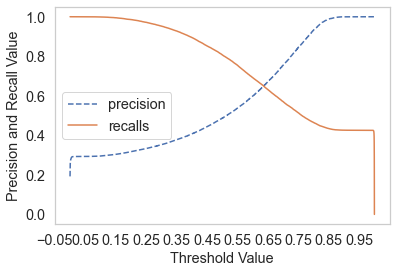

In [89]:
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    threshold_boundary = thresholds.shape[0]
    # plot precision
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    # plot recall
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recalls')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    plt.xlabel('Threshold Value'); plt.ylabel('Precision and Recall Value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr1.predict_proba(X_test)[:,1])

In [90]:
# Stats Model

In [91]:
import statsmodels.api as sm
x_sm = sm.add_constant(X_train)
sm_model = sm.OLS(y_train, x_sm)
result = sm_model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_status   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.462
Method:                 Least Squares   F-statistic:                     4439.
Date:                Mon, 27 May 2024   Prob (F-statistic):               0.00
Time:                        23:54:47   Log-Likelihood:                -44209.
No. Observations:              248162   AIC:                         8.852e+04
Df Residuals:                  248113   BIC:                         8.903e+04
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1811      0.037     -4.849      0.0

# Actionable Insights & Recommendations

### Insights

1. **Customer Behavior:**
   - 80% of customers fully repay their loans.
   - 20% of customers default on their loans.

2. **Model Performance:**
   - The model achieves a 94% F1-score for predicting fully paid loans and a 62% F1-score for predicting defaults.
   - The ROC AUC score is 0.73, indicating that the model correctly classifies 73% of the instances.
   - Cross-validation accuracy is similar to testing accuracy, suggesting the model generalizes well to unseen data.
   - After balancing the dataset, there is a significant change in precision and recall scores for both classes.
   - Logistic Regression classifier achieves a test accuracy of 0.891.

3. **Loan Characteristics:**
   - Loans with lower grades (e.g., G grade) have a high default probability (approximately 55%).
   - High-interest loans have a 40% chance of default.
   - Low-interest loans have a higher probability of being fully repaid (over 90%).
   - Joint loans have the highest probability of full repayment.

4. **Borrower Attributes:**
   - Borrowers with long employment durations tend to be more stable.
   - Debt consolidation is the primary purpose for loans, indicating a trend towards financial management.

5. **Data Insights:**
   - High outlier percentages in features like Public Record (Pub_Rec), Revolving Balance (Revol_Bal), and Annual Income (Annual_Inc) necessitate careful data handling.
   - Strong correlation between loan amount and installment (0.95 Pearson, 0.97 Spearman).

6. **Geographical Insights:**
   - Significant regional variations in default rates, with states like Minnesota having the lowest and Wyoming the highest default rates.

7. **Risk Factors:**
   - Longer-term loans (60 months) and higher loan grades (closer to G) are associated with higher risk.
   - Verification status alone does not guarantee loan repayment.

### Recommendations

1. **Model Improvement:**
   - Collect more data, use more complex models, or tune hyperparameters to improve model performance, particularly for predicting defaults.

2. **Loan Portfolio Management:**
   - Focus on improving the terms and conditions for low-grade loans (e.g., G grade) to reduce default rates.
   - Promote low-interest loans and joint loans due to their higher repayment probabilities.

3. **Risk Assessment:**
   - Adjust risk assessment models to give more weight to high-interest rates, higher loan amounts, and higher Debt-to-Income (DTI) ratios.
   - Incorporate geographical data into risk assessments to account for regional variations in default rates.

4. **Data Handling:**
   - Implement robust data validation and outlier management strategies to ensure data accuracy.

5. **Tailored Products:**
   - Develop tailored loan products for the most common borrower segments (B, C, and A grade borrowers) to enhance product-market fit.
   - Diversify loan purposes beyond debt consolidation to spread risk.

6. **Loan Term Structuring:**
   - Offer more flexible terms for higher-grade loans and consider stricter terms for longer-term and lower-grade loans to mitigate risk.

7. **Monitoring and Adjustments:**
   - Continuously monitor and adjust credit scoring models in response to changes in borrower behavior and economic conditions.

8. **Further Analysis:**
   - Conduct further statistical tests to validate the significance of observed correlations and insights, ensuring that lending strategies are data-driven.

9. **User Education:**
   - Educate borrowers on the benefits of lower interest and joint loans to encourage uptake of these lower-risk loan products.

# Questionnaire

1. **How can we make sure that our model can detect real defaulters and there are fewer false positives? This is important as we can lose out on an opportunity to finance more individuals and earn interest on it.**

   - **Answer:** To minimize false positives, oversampling techniques like SMOTE should be used in model creation. Additionally, using complex algorithms such as SVM, Decision Trees, Random Forests, and hyperparameter tuning can help. The goal is to enhance model precision, ensuring that genuine defaulters are detected while reducing false positives.

2. **Comment about the correlation between Loan Amount and Installment features.**

   - **Answer:** The Spearman correlation coefficient between Loan Amount and Installment is very high (0.97), indicating high multicollinearity. This results in a high VIF value (11.91), leading to the exclusion of the Loan Amount feature in the model creation.

3. **The majority of people have home ownership as ____.**

   - **Answer:** The majority of people have home ownership as MORTGAGE (about 50%), followed by RENT (~40%).

4. **People with grades ‘A’ are more likely to fully pay their loan. (T/F)**

   - **Answer:** True. Out of all people with grade 'A', 93% have fully paid their loan.

5. **Name the top 2 afforded job titles.**

   - **Answer:** Teacher and Manager.

6. **Thinking from a bank's perspective, which metric should our primary focus be on?**
   1. ROC AUC
   2. Precision
   3. Recall
   4. F1 Score

   - **Answer:** The best metric to consider is the F1 score as it balances both precision and recall, ensuring that the bank does not miss potential customers while also avoiding giving loans to defaulters.

7. **How does the gap in precision and recall affect the bank?**

   - **Answer:** A recall score of 0.99 and a precision score of 0.88 indicate more false positives than false negatives. If recall is low (high FN), the bank loses opportunity cost. If precision is low (high FP), NPAs may increase.

8. **Which were the features that heavily affected the outcome?**

   - **Answer:** Using RFE, the top 20 features impacting the outcome include:
     - Interest Rate (int_rate)
     - Loan subgrade (sub_grade)
     - Number of payments on the loan (term)
     - Home ownership (home_ownership)
     - Purpose of the loan (purpose)
     - Application type (application_type)
     - Pincode (from address)
     - Job title supplied by the Borrower (emp_title)

9. **Will the results be affected by geographical location? (Yes/No)**

   - **Answer:** Yes. The pincode (derived from address) has a significant impact on the outcome.